In [1]:
import helper
import pandas as pd
from utils import *

import time
import numpy as np
import math

In [2]:
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

# Introduction

Stock price prediction is one of the most rewarding problems in modern finance, where the accurate forecasting of future stock prices can yield significant profit and reduce the risks. LSTM (Long Short-Term Memory) is a recurrent Neural Network (RNN) applicable to a broad range of problems aiming to analyze or classify sequential data. LSTM can be used to predict the future stock price based on the historical data sequences. [Recent studies](https://arxiv.org/abs/2009.01783) have shown that its efficiency and trainability can be improved by leveraging a quantum-classical hybrid model of LSTM. QLSTM proved to learn significantly more information after the first training epoch than its classical counterpart. Thus, we implement a variational quantum-classical hybrid algorithm engaging machine learning techniques within the LSTM model framework in order to predict stock price movement.

## Quick Outline of Notebook 

The notebook will proceed in the following manner:

1. Data Collection and Processing
2. Using Classical LSTM to perform stock price prediction
3. Defining QLSTM and using it to perform stock price prediction
4. Comparison between LSTM and QLSTM

Note that for the LSTM, we would be using PyTorch; while for the QLSTM we would be using PyTorch and Pennylane. We focus on stock price prediction of Merck & Co. (MRK).

# Data Collection and Processing

In this section we collect the data and process it so that we can use it for LSTM. 

## Stock price data for MRK

We collect the historical stock prices data for MRK using Yahoo Finance, and we want to predict the Closing prices.

In [4]:
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)

In [5]:
dataset_ex_df = pd.read_csv('MRK.csv', header=0, parse_dates=[0], date_parser=helper.date_parser)

In [6]:
dataset_ex_df[['Date', 'Close']].head()

,Date,Close
0,2009-07-27,29.360687
1,2009-07-28,28.645039
2,2009-07-29,28.501907
3,2009-07-30,28.568703
4,2009-07-31,28.635496


In [7]:
print('There are {} number of days in the dataset.'.format(dataset_ex_df.shape[0]))

There are 2738 number of days in the dataset.


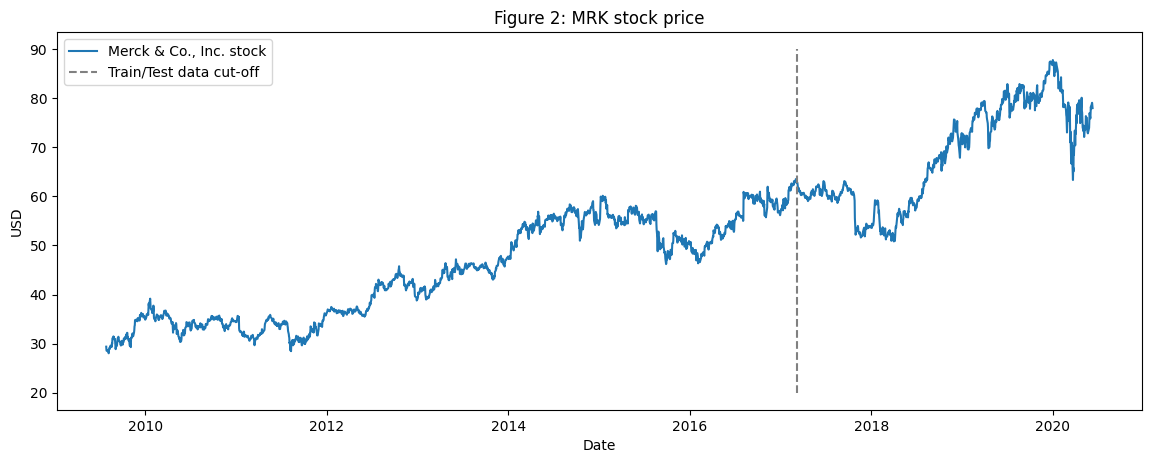

In [8]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(dataset_ex_df['Date'], dataset_ex_df['Close'], label='Merck & Co., Inc. stock')
plt.vlines(datetime.date(2017,3, 7), 20, 90, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: MRK stock price')
plt.legend()
plt.show()

In [9]:
num_training_days = int(dataset_ex_df.shape[0]*.7)
num_test_days = dataset_ex_df.shape[0]-num_training_days
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, num_test_days))

Number of training days: 1916. Number of test days: 822.


In [10]:
dataset_ex_df['Date'][1916]

Timestamp('2017-03-07 00:00:00')

## Technical Indicators

As one of the independent variables, we also get some technical indicators of the MRK data. This includes the moving averages, moving averages convergence divergences (MACD), momentum, Fourier transforms (of various components), ARIMA model etc.. Please check the helper file for more details.

In [11]:
dataset_TI_df = helper.get_technical_indicators(dataset_ex_df, "Close")
dataset_TI_df = dataset_TI_df[20:]
dataset_TI_df.reset_index(drop=True, inplace=True)
dataset_TI_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
0,2009-08-24,31.479008,31.488550,30.830153,31.011450,20.021574,14227229,30.050436,29.200291,29.514006,29.867322,0.353316,0.835852,30.871996,27.528586,30.897808,30.011450,3.401579
1,2009-08-25,31.402672,31.536261,31.011450,31.440840,20.298801,20081566,30.318975,29.299346,29.688906,30.115697,0.426791,0.963549,31.226444,27.372247,31.259829,30.440840,3.415785
2,2009-08-26,31.316793,31.469465,30.982824,31.183207,20.132467,10438080,30.564340,29.420211,29.822316,30.283528,0.461212,1.026446,31.473102,27.367319,31.208748,30.183207,3.407286
3,2009-08-27,31.106871,31.488550,30.734734,31.364504,20.249514,10302154,30.858779,29.556525,29.957940,30.452906,0.494965,1.086420,31.729366,27.383684,31.312585,30.364504,3.413274
4,2009-08-28,31.412214,31.412214,30.648855,30.839695,19.910694,12640452,30.973283,29.664667,30.034423,30.513340,0.478916,1.094567,31.853801,27.475534,30.997325,29.839695,3.395840


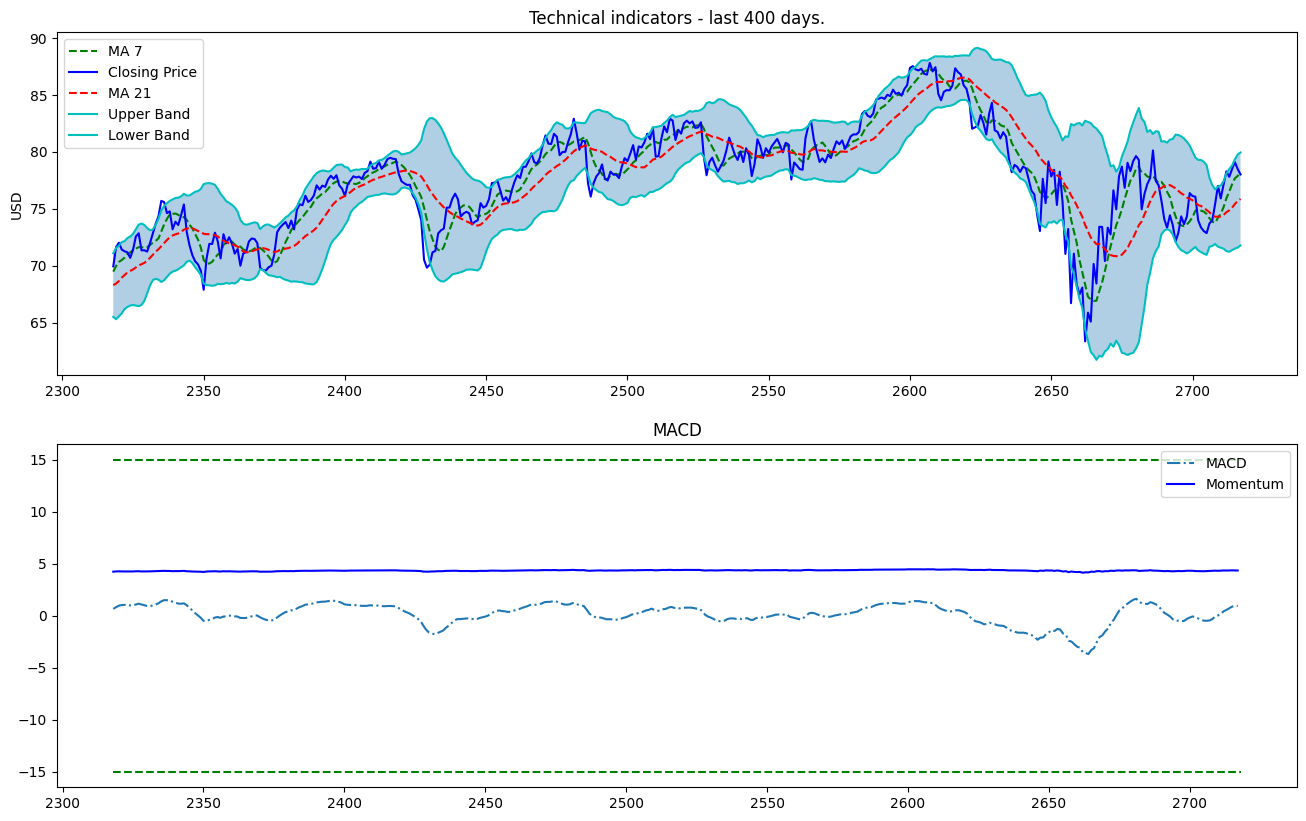

In [12]:
helper.plot_technical_indicators(dataset_TI_df, 400)

In [13]:
data_FT = dataset_ex_df[['Date', 'Close']]

In [14]:
close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

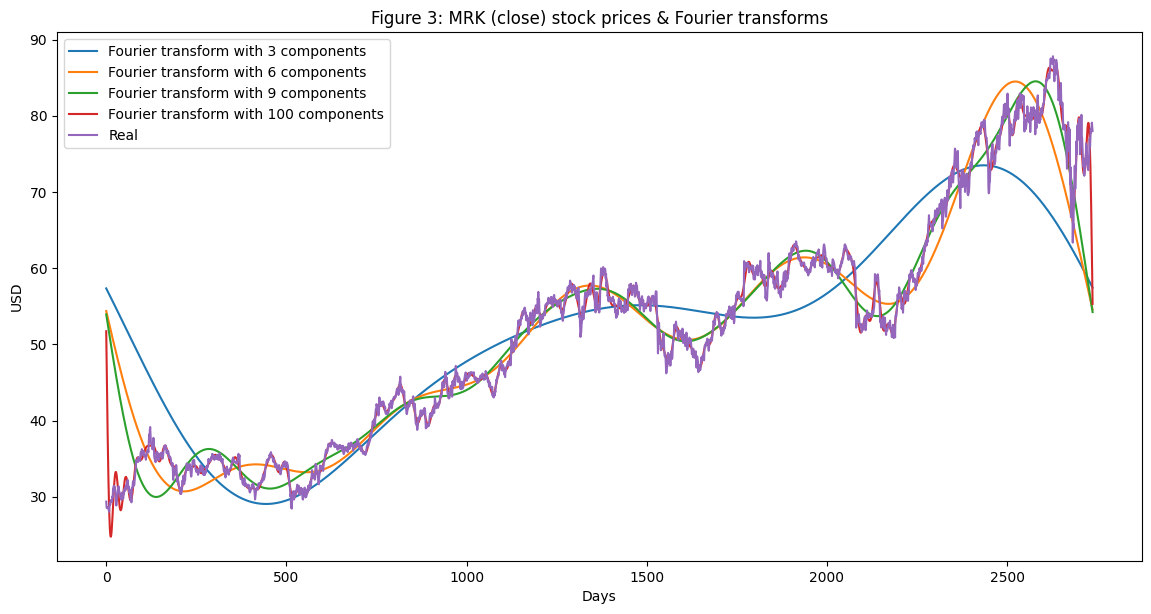

In [15]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['Close'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: MRK (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

In [16]:
len(fft_list_m10)

2738

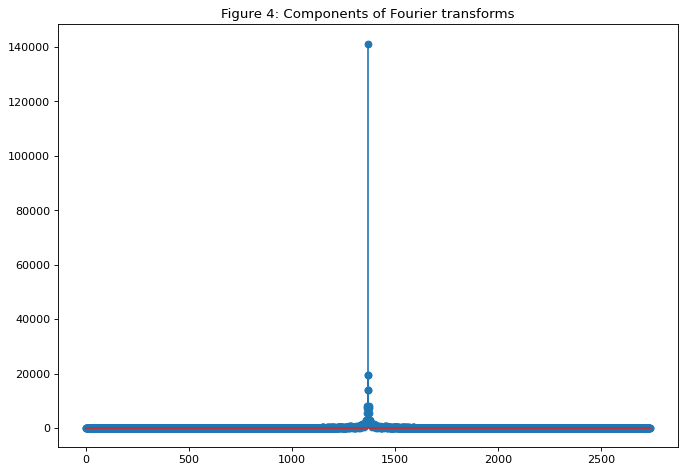

In [17]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

In [18]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_FT['Close']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit()
#model_fit = model.fit(disp=0)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2738
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2985.587
Date:                Wed, 23 Feb 2022   AIC                           5983.174
Time:                        11:19:51   BIC                           6018.662
Sample:                             0   HQIC                          5995.999
                               - 2738                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1034      0.012     -8.991      0.000      -0.126      -0.081
ar.L2          0.0311      0.010      3.104      0.002       0.011       0.051
ar.L3         -0.0121      0.011     -1.103      0.2

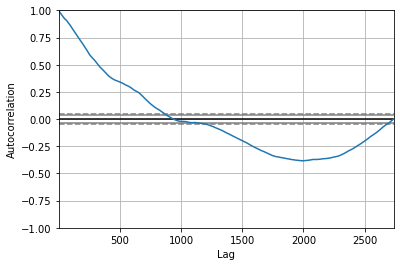

<Figure size 800x560 with 0 Axes>

In [19]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

In [20]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    #model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [21]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 0.957


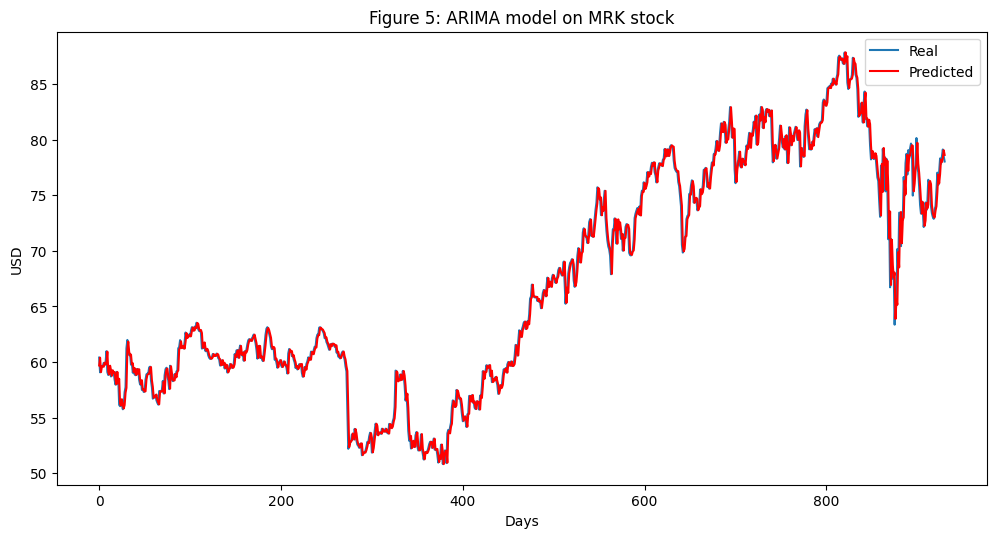

In [22]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on MRK stock')
plt.legend()
plt.show()

In [23]:
predictions

[59.694296369256385,
 60.384597673860966,
 59.09256055470492,
 59.57125202915269,
 59.663322569955504,
 59.576192035847406,
 59.940731187636565,
 59.77265185985804,
 59.882996250876126,
 60.93379280342932,
 59.12160406630059,
 58.87726582658457,
 59.66610018183937,
 59.280731849733186,
 58.768877862093326,
 59.25543871121194,
 59.02145331162797,
 59.09124849480025,
 58.43952768298736,
 57.99529974907615,
 59.1075607506703,
 58.10066980810338,
 58.495037766839644,
 56.2673901643319,
 56.08265336772973,
 56.65487811192913,
 56.16669157193061,
 55.82115431451898,
 56.13303663933286,
 57.238418569242796,
 57.680908025970766,
 61.0654427357495,
 61.833580460336115,
 60.9033857844882,
 60.58878757756202,
 60.66824799739304,
 59.79032908892899,
 59.89025018870299,
 59.09808256688518,
 59.46295374184776,
 58.93288863755622,
 58.83173705000183,
 59.3777724211533,
 58.963108448727425,
 59.34358909991998,
 58.41681901608194,
 57.99939108043201,
 58.36133913502173,
 57.52361861990992,
 57.56629982

## Correlated Assets

We collect correlated assets of MRK as well. To decide what the correlated assets are, we looked at the following sites:
    
https://www.tipranks.com/stocks/mrk/similar-stocks

https://seekingalpha.com/symbol/MRK/peers/related-stocks 

https://marketchameleon.com/Overview/MRK/Similar/
    
As well as including some indexes that it is in

In [24]:
import yfinance as yf

1. SNP 500

In [25]:
SNP = yf.Ticker("^GSPC")

In [26]:
SNP_data = SNP.history(start="2009-07-27", end="2020-06-11")
SNP_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-07-27,978.630005,982.489990,972.289978,982.179993,4631290000,0,0
2009-07-28,981.479980,982.349976,969.349976,979.619995,5490350000,0,0
2009-07-29,977.659973,977.760010,968.650024,975.150024,5178770000,0,0
2009-07-30,976.010010,996.679993,976.010010,986.750000,6035180000,0,0
2009-07-31,986.799988,993.179993,982.849976,987.479980,5139070000,0,0
...,...,...,...,...,...,...,...
2020-06-04,3111.560059,3128.909912,3090.409912,3112.350098,6428130000,0,0
2020-06-05,3163.840088,3211.719971,3163.840088,3193.929932,8617590000,0,0
2020-06-08,3199.919922,3233.129883,3196.000000,3232.389893,8437380000,0,0


2. Pfizer

In [27]:
PFE = yf.Ticker("PFE")

In [28]:
PFE_data = PFE.history(start="2009-07-27", end="2020-06-11")
PFE_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-07-27,9.705485,9.835443,9.581434,9.817721,50004184,0.0,0
2009-07-28,9.740926,9.841348,9.427846,9.469196,79445882,0.0,0
2009-07-29,9.451476,9.498734,9.238818,9.303797,64191867,0.0,0
2009-07-30,9.427842,9.605057,9.386492,9.416028,51094020,0.0,0
2009-07-31,9.516455,9.557805,9.392405,9.410126,45270143,0.0,0
...,...,...,...,...,...,...,...
2020-06-04,31.719292,32.234475,31.710410,31.985765,27013388,0.0,0
2020-06-05,32.190057,32.412121,31.870288,31.967997,36705655,0.0,0
2020-06-08,31.799234,32.509832,31.692646,32.500950,30194149,0.0,0


3. Johnson and Johnson

In [29]:
JNJ = yf.Ticker("JNJ")

In [30]:
JNJ_data = JNJ.history(start="2009-07-27", end="2020-06-11")
JNJ_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-07-27,42.245868,42.383273,41.648144,42.094719,7937700,0.0,0
2009-07-28,41.929822,42.300823,41.634397,41.854248,9025500,0.0,0
2009-07-29,41.730588,42.211511,41.696234,42.019142,10522700,0.0,0
2009-07-30,42.362654,42.919154,42.266469,42.451969,12636500,0.0,0
2009-07-31,42.479457,42.713047,41.758067,41.833641,13230900,0.0,0
...,...,...,...,...,...,...,...
2020-06-04,140.361996,141.863135,139.195499,140.295059,8170500,0.0,0
2020-06-05,141.212968,143.077447,140.170774,140.840073,9725400,0.0,0
2020-06-08,139.482345,141.136471,139.348485,140.333313,7555600,0.0,0


Rejected: Organon & Co.

In [31]:
OGN = yf.Ticker("OGN")

In [32]:
OGN_data = OGN.history(period="max")
OGN_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-05-14,30.473025,32.684776,30.473025,32.684776,342900,0.0,0
2021-05-17,33.422030,34.405031,33.422030,33.520329,31500,0.0,0
2021-05-18,33.893867,37.767875,33.893867,36.862530,48900,0.0,0
2021-05-19,36.371029,37.108280,36.371029,36.862530,43900,0.0,0
2021-05-20,36.862530,37.108280,36.862530,37.108280,22900,0.0,0
...,...,...,...,...,...,...,...
2022-02-15,34.799999,35.308998,34.799999,35.220001,1931800,0.0,0
2022-02-16,35.299999,36.490002,35.220001,36.340000,3114100,0.0,0
2022-02-17,35.389999,36.939999,34.889999,36.369999,4587400,0.0,0


4. Bristol-Myers Squibb Company

In [33]:
BMY = yf.Ticker("BMY")

In [34]:
BMY_data = BMY.history(start="2009-07-27", end="2020-06-11")
BMY_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-07-27,14.151239,14.184225,13.867554,14.105057,12992300,0.0,0
2009-07-28,14.032492,14.184230,13.841169,13.973116,11360400,0.0,0
2009-07-29,13.900546,14.269995,13.900546,14.243607,13095000,0.0,0
2009-07-30,14.408534,14.494299,14.217212,14.223809,11853800,0.0,0
2009-07-31,14.237004,14.408534,14.032487,14.342561,17007400,0.0,0
...,...,...,...,...,...,...,...
2020-06-04,56.618244,57.820270,56.618244,57.630974,13476900,0.0,0
2020-06-05,57.905455,58.463877,57.290244,58.047428,11862600,0.0,0
2020-06-08,57.356497,58.142075,57.167205,58.142075,12549100,0.0,0


5. Viatris Inc

In [35]:
VTRS = yf.Ticker("VTRS")

In [36]:
VTRS_data = VTRS.history(start="2009-07-27", end="2020-06-11")
VTRS_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-07-27,12.782050,12.801595,11.394396,11.824374,50917600,0,0
2009-07-28,12.029592,13.065446,11.697337,12.273897,46254500,0,0
2009-07-29,12.381391,12.703874,12.127313,12.615924,13872800,0,0
2009-07-30,12.997040,13.241346,12.615924,12.830913,18346600,0,0
2009-07-31,12.860228,13.133850,12.830912,12.889544,8805200,0,0
...,...,...,...,...,...,...,...
2020-06-04,16.925469,17.296814,16.866836,17.296814,4732300,0,0
2020-06-05,17.736562,18.293577,17.140458,17.267496,7859900,0,0
2020-06-08,17.589980,18.801734,17.482485,18.352213,10387700,0,0


6. Amgen Inc

In [37]:
AMGN = yf.Ticker("AMGN")

In [38]:
AMGN_data = AMGN.history(start="2009-07-27", end="2020-06-11")
AMGN_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-07-27,46.776816,47.152504,45.833766,46.592808,10946800,0.0,0
2009-07-28,48.080229,48.179902,47.091176,47.857883,18802100,0.0,0
2009-07-29,48.011228,48.685931,47.811885,48.478920,11811900,0.0,0
2009-07-30,48.816264,49.452632,48.294905,48.386909,9855700,0.0,0
2009-07-31,48.333252,48.770275,47.535875,47.773556,6361100,0.0,0
...,...,...,...,...,...,...,...
2020-06-04,209.488745,212.031791,208.008462,209.593124,2392800,0.0,0
2020-06-05,208.473400,214.404027,207.050050,214.138336,3714600,0.0,0
2020-06-08,211.861010,214.688729,210.418677,214.214279,2270500,0.0,0


7. Verizon Comms

In [39]:
VZ = yf.Ticker("VZ")

In [40]:
VZ_data = VZ.history(start="2009-07-27", end="2020-06-11")
VZ_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-07-27,16.235546,16.375597,15.830954,16.079933,20398043,0.0,0.0
2009-07-28,16.017684,16.297786,15.955440,16.287413,17952338,0.0,0.0
2009-07-29,16.214795,16.603826,16.126615,16.588264,22084490,0.0,0.0
2009-07-30,16.681635,16.956550,16.645325,16.759441,20638583,0.0,0.0
2009-07-31,16.723131,16.775001,16.515648,16.634951,27609451,0.0,0.0
...,...,...,...,...,...,...,...
2020-06-04,52.479259,53.061948,52.266527,52.923214,16147300,0.0,0.0
2020-06-05,53.413411,53.755626,52.793725,53.404163,17105600,0.0,0.0
2020-06-08,53.320928,53.829627,52.969462,53.727886,14963000,0.0,0.0


8. Sanofi - American Depositary Shares

In [41]:
SNY = yf.Ticker("SNY")

In [42]:
SNY_data = SNY.history(start="2009-07-27", end="2020-06-11")
SNY_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-07-27,20.203553,20.264961,20.019325,20.185129,1018800,0.0,0
2009-07-28,20.559722,20.694823,20.332510,20.535158,1306000,0.0,0
2009-07-29,20.443048,20.547442,20.111439,20.258821,2222600,0.0,0
2009-07-30,20.093016,20.406201,20.050030,20.172846,1707600,0.0,0
2009-07-31,20.099156,20.203553,19.865802,20.043888,1355800,0.0,0
...,...,...,...,...,...,...,...
2020-06-04,47.862264,48.575334,47.688819,48.132076,2586700,0.0,0
2020-06-05,48.478975,48.565700,48.132077,48.276615,1077900,0.0,0
2020-06-08,48.315160,48.980050,48.045352,48.960777,1644100,0.0,0


9. Glaxosmithkline PLC

In [43]:
GSK = yf.Ticker("GSK")

In [44]:
GSK_data = GSK.history(start="2009-07-27", end="2020-06-11")
GSK_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-07-27,19.711155,19.808455,19.537037,19.793093,1568300,0.000,0
2009-07-28,19.752125,19.916000,19.649702,19.813578,1105500,0.000,0
2009-07-29,19.943662,20.005856,19.767445,19.897017,1666700,0.461,0
2009-07-30,20.036949,20.213167,19.917744,19.917744,1047200,0.000,0
2009-07-31,19.897020,19.995496,19.694888,19.845192,1079200,0.000,0
...,...,...,...,...,...,...,...
2020-06-04,38.506410,38.866196,38.377252,38.423382,2802300,0.000,0
2020-06-05,38.497180,38.810840,38.395701,38.469505,2779000,0.000,0
2020-06-08,38.746266,39.087601,38.534084,39.087601,5348700,0.000,0


10. Eli Lilly And Company

In [45]:
LLY = yf.Ticker("LLY")

In [46]:
LLY_data = LLY.history(start="2009-07-27", end="2020-06-11")
LLY_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-07-27,22.936001,23.153374,22.731802,23.153374,4740800,0.0,0
2009-07-28,23.061139,23.265338,22.738377,23.100662,4896400,0.0,0
2009-07-29,23.047973,23.232408,22.797665,22.988689,4125500,0.0,0
2009-07-30,23.199478,23.482720,22.995280,23.087498,4579700,0.0,0
2009-07-31,23.061137,23.324619,22.975508,22.982094,5893600,0.0,0
...,...,...,...,...,...,...,...
2020-06-04,147.830406,149.122124,145.402339,146.373566,3328700,0.0,0
2020-06-05,145.392578,147.393302,144.071710,144.916687,4578800,0.0,0
2020-06-08,142.527464,144.955530,142.304086,144.916687,4076400,0.0,0


11. Novartis Ag

In [47]:
NVS = yf.Ticker("NVS")

In [48]:
NVS_data = NVS.history(start="2009-07-27", end="2020-06-11")
NVS_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-07-27,25.491292,25.566523,25.236669,25.531801,809323,0.0,0.0
2009-07-28,25.473928,25.601242,25.282962,25.589668,759773,0.0,0.0
2009-07-29,25.398701,25.468145,25.109356,25.248241,1394888,0.0,0.0
2009-07-30,25.572310,25.919525,25.421851,25.815359,1414976,0.0,0.0
2009-07-31,26.012120,26.538727,25.965824,26.399841,1835150,0.0,0.0
...,...,...,...,...,...,...,...
2020-06-04,82.201473,83.009063,81.663080,81.836136,1801100,0.0,0.0
2020-06-05,82.364910,83.114817,82.201470,82.576424,1533300,0.0,0.0
2020-06-08,82.432213,82.884082,81.893820,82.364914,1956200,0.0,0.0


12. NYSE

In [49]:
NYSE = yf.Ticker("^NYA")

In [50]:
NYSE_data = NYSE.history(start="2009-07-27", end="2020-06-11")
NYSE_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-07-27,6320.240234,6365.459961,6317.450195,6364.660156,4631290000,0,0
2009-07-28,6364.649902,6364.649902,6259.589844,6328.669922,5490350000,0,0
2009-07-29,6328.680176,6328.680176,6241.580078,6280.569824,5178770000,0,0
2009-07-30,6280.569824,6434.390137,6280.569824,6384.310059,6035180000,0,0
2009-07-31,6384.310059,6455.049805,6365.220215,6424.279785,5139070000,0,0
...,...,...,...,...,...,...,...
2020-06-04,12236.740234,12328.509766,12202.360352,12286.980469,6428130000,0,0
2020-06-05,12640.980469,12752.139648,12600.700195,12641.440430,8617590000,0,0
2020-06-08,12734.540039,12836.679688,12688.549805,12836.599609,8437380000,0,0


13. NASDAQ

In [51]:
NASDAQ = yf.Ticker("^IXIC")

In [52]:
NASDAQ_data = NASDAQ.history(start="2009-07-27", end="2020-06-11")
NASDAQ_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-07-27,1964.619995,1971.380005,1946.949951,1967.890015,2141690000,0,0
2009-07-28,1957.260010,1978.430054,1947.890015,1975.510010,2206850000,0,0
2009-07-29,1965.319946,1970.650024,1953.359985,1967.760010,2072650000,0,0
2009-07-30,1986.209961,2009.810059,1980.079956,1984.300049,2525670000,0,0
2009-07-31,1980.719971,1995.050049,1977.650024,1978.500000,2190380000,0,0
...,...,...,...,...,...,...,...
2020-06-04,9649.650391,9716.139648,9560.410156,9615.809570,6074320000,0,0
2020-06-05,9703.540039,9845.690430,9685.349609,9814.080078,6572850000,0,0
2020-06-08,9823.440430,9927.129883,9780.610352,9924.750000,6143120000,0,0


## Sentiment Analysis

We got the data for the financial news from:

https://www.kaggle.com/miguelaenlle/massive-stock-news-analysis-db-for-nlpbacktests

And we use finBERT to perform the sentiment analysis

In [53]:
analyst_ratings_processed = pd.read_csv ('analyst_ratings_processed.csv')
print(analyst_ratings_processed)

         Unnamed: 0                                              title  \
0               0.0            Stocks That Hit 52-Week Highs On Friday   
1               1.0         Stocks That Hit 52-Week Highs On Wednesday   
2               2.0                      71 Biggest Movers From Friday   
3               3.0       46 Stocks Moving In Friday's Mid-Day Session   
4               4.0  B of A Securities Maintains Neutral on Agilent...   
...             ...                                                ...   
1400464   1413844.0             Top Narrow Based Indexes For August 29   
1400465   1413845.0  Recap: Wednesday's Top Percentage Gainers and ...   
1400466   1413846.0  UPDATE: Oppenheimer Color on China Zenix Auto ...   
1400467   1413847.0  Oppenheimer Initiates China Zenix At Outperfor...   
1400468   1413848.0  China Zenix Auto International Opens For Tradi...   

                              date stock  
0        2020-06-05 10:30:00-04:00     A  
1        2020-06-03 10:45

In [54]:
MRK_headlines = analyst_ratings_processed[analyst_ratings_processed['stock'] == 'MRK']
MRK_headlines

,Unnamed: 0,title,date,stock
838963,850715.0,Shares of several healthcare companies are tra...,2020-06-11 10:22:00-04:00,MRK
838964,850716.0,Johnson & Johnson To Start Coronavirus Vaccine...,2020-06-11 00:16:00-04:00,MRK
838965,850717.0,The Daily Biotech Pulse: Keytruda Setback For ...,2020-06-10 07:30:00-04:00,MRK
838966,850718.0,Merck Announces That The Phase 3 KEYNOTE-361 T...,2020-06-09 16:13:00-04:00,MRK
838967,850719.0,"The Week Ahead In Biotech: Viela FDA Decision,...",2020-06-07 13:43:00-04:00,MRK
...,...,...,...,...
842308,854069.0,BenchmarkJournal.com Free Analyst Review for A...,2009-08-17 08:14:00-04:00,MRK
842309,854070.0,Trends in the U.K. and Irish Pharmaceutical an...,2009-08-17 05:01:00-04:00,MRK
842310,854071.0,ParagonReport.com Complimentary Market Update ...,2009-08-10 13:35:00-04:00,MRK
842311,854072.0,ParagonReport.com Complimentary Market Update ...,2009-08-07 11:30:00-04:00,MRK


Model

In [55]:
from pathlib import Path
from transformers import AutoModelForSequenceClassification

In [56]:
project_dir = Path.cwd().parent

In [57]:
cl_path = project_dir/'Stock GANs'/'model'

In [58]:
import ipywidgets
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

Predict

In [59]:
sample_text = "Stock crashed last night due to virus concerns"

In [60]:
import torch
inputs = tokenizer(sample_text, return_tensors="pt")
inputs

{'input_ids': tensor([[ 101, 4518, 8007, 2197, 2305, 2349, 2000, 7865, 5936,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [61]:
outputs = model(**inputs)

In [62]:
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[-1.7292,  2.7642, -0.5491]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [63]:
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

tensor([[0.0107, 0.9546, 0.0347]], grad_fn=<SoftmaxBackward0>)


In [64]:
predictions.detach().numpy()[0][0]

0.010675142

In [65]:
MRK_headlines

,Unnamed: 0,title,date,stock
838963,850715.0,Shares of several healthcare companies are tra...,2020-06-11 10:22:00-04:00,MRK
838964,850716.0,Johnson & Johnson To Start Coronavirus Vaccine...,2020-06-11 00:16:00-04:00,MRK
838965,850717.0,The Daily Biotech Pulse: Keytruda Setback For ...,2020-06-10 07:30:00-04:00,MRK
838966,850718.0,Merck Announces That The Phase 3 KEYNOTE-361 T...,2020-06-09 16:13:00-04:00,MRK
838967,850719.0,"The Week Ahead In Biotech: Viela FDA Decision,...",2020-06-07 13:43:00-04:00,MRK
...,...,...,...,...
842308,854069.0,BenchmarkJournal.com Free Analyst Review for A...,2009-08-17 08:14:00-04:00,MRK
842309,854070.0,Trends in the U.K. and Irish Pharmaceutical an...,2009-08-17 05:01:00-04:00,MRK
842310,854071.0,ParagonReport.com Complimentary Market Update ...,2009-08-10 13:35:00-04:00,MRK
842311,854072.0,ParagonReport.com Complimentary Market Update ...,2009-08-07 11:30:00-04:00,MRK


In [66]:
for headline in MRK_headlines['title']:
    print(headline)

Shares of several healthcare companies are trading lower in sympathy with the overall market following an increase in coronavirus cases in some US states that have reopened, leading to concerns of a second wave of the virus.
Johnson & Johnson To Start Coronavirus Vaccine Human Trials Ahead Of Schedule In July
The Daily Biotech Pulse: Keytruda Setback For Merck, Denali Pulls The Plug On Neurological Asset
Merck Announces That The Phase 3 KEYNOTE-361 Trial Evaluating KEYTRUDA As Monotherapy And In Combination With Chemotherapy In Patients With Advanced Or Metastatic Urothelial Carcinoma
The Week Ahead In Biotech: Viela FDA Decision, Hematology Conference Take Center Stage
The Daily Biotech Pulse: Adamas Rallies On FDA Acceptance, Oxford Immunotech Reportedly Gets $400M Bid
Merck Reports FDA Approved RECARBIO For Treatment Of Adults with Hospital-Acquired and Ventilator-Associated Bacterial Pneumonia
Ex-FDA Chief On White House's Coronavirus Vaccine Shortlist: 'They Chose Very Novel Platf

8 Firms To Debut On The Markets This Week
AstraZeneca, Merck Rapidly Advance LYNPARZA in Japan With a NDA To Japan's Pharmaceuticals and Medical Devices Agency
A Preview Of Next Week's Blue-Chip Earnings
Fierce Pharma Reports Merck Lays Off 1,800 U.S. Sales Reps To Overhaul Primary Care Marketing
OncoSec Shares Spike 17% After New Data Defended
White House 'Shenanigans' Represent A Buying Opportunity: Cramer
Benzinga's Top Upgrades, Downgrades For October 18, 2017
Boosted By Keytruda, Citi Upgrades Merck To Buy For The First Time Ever
Merck Reports FDA Accepted Regulatory Submission For LYNPARZA In Metastatic Breast Cancer, Grants Priority Review
UPDATE: Merck Highlights KEYTRUDA Data 'Showed Median Overall Survival of 30.0 Months for KEYTRUDA Group Compared to 14.2 Months for Chemotherapy Group'
Merck Reports KEYTRUDA More Than Doubled Median Overall Survival Compared to Chemotherapy After 2 Years of Follow Up in First-Line Treatment of Patients with Metastatic NSCLC with High Levels 

PPH May Be Home To Hedge Fund Hotels, But This ETF Can Endure
SocGen Picks New Favorites In Big Pharma
Societe Generale Initiates Coverage on Merck & Co at Buy
Merck Will Present New KEYTRUDA Data At AACR Meeting Apr. 16-20th
WHO Says Number of Adults with Diabetes has Quadrupled Since 1980 -AFP
Advaxis, Merck Combination Trial Evaluating ADXS-PSA Launches Third Dose-Escalation Cohort
The Stocks That Moved The S&P, Dow And Nasdaq Today
This Data Signals The End For Merck's Anacetrapib
Make A House Call With A Familiar Healthcare ETF
Biopharma Names LLY, PFE, MRK, And More Popping Higher Following Reports China FDA To Investigate Improper Vaccine Trading
Data Shows Gilead's HCV Franchise Is Surviving New Competition
Patent Expert: It's Not Over For Gilead, Still Has Strong Defense Against Merck
Jury Rules Merck Patents Valid…Bad For Gilead?
Gilead -2.5% Premarket Following Verdict Tuesday Validating Merck's Hep C Patents
Organovo Is A Company 3D Printing Human Tissue And Its CEO Is Exci

Merck Issues Statement on FDA Advisory Committee Meeting Results for Suvorexant 
FDA Panel Votes 8-7 Merck's Suvorexant Unsafe in Higher Doses
FDA Panel Votes 13-3 Merck's Suvorexant is Safe in Low Doses
FDA Panel Finds Merck Doesn't Need to Study 10mg Suvorexant
FDA Says Merck Insomnia Drug Helps Patients Stay Asleep -Bloomberg
FDA Panel Votes 12 Yes 4 No on Effectiveness of Merck Insomnia Drug
PreMarket Info Recap for May 22, 2013
Merck FDA Advisory Committee Meeting for Insomnia Drug Suvorexant Begins at 8 AM ET
Merck to Take Initial Delivery of ~99.5M Shares
Merck Announces $5B Accelerated Buyback Plan
ISI Suggesting the FDA Report on Merck Points to 'Some Risk' from Panel
Merck Prices $6.5B Debt Offering
Moody's Downgrades Merck's Guaranteed Senior Unsecured Rating from Aa3 to A1
Short Interest in Vertex Rises, in Celgene Falls
Merck, Glaxo Reduce Prices 95% for HPV Vaccine in Poor Nations
Merck Announces FDA Acceptance of Biologics License Application for Investigational Ragweed 

News Summary for August 9, 2011
Benzinga's Top Upgrades
Jefferies Upgrades Merck & Co. To Buy, Lowers PT To $37
Merck and Serum Institute Announce Collaboration to Develop and Expand Global Access to Pneumococcal Conjugate Vaccine 
Aw Snap, Is Market Gonna Crackle or Pop?
Weak Data in Focus  08-01-2011
Merck To Close Mission Bay Research Center
J.P. Morgan Maintains Overweight Rating On Merck & Co
ARIAD Announces That Merck Has Submitted for Approval of Ridaforolimus, an Investigational mTOR Inhibitor, in the EU
6 Deeply Undervalued Biotech Stocks
Looking at T. Boone Pickens' 6 Newest Energy Stock Buys
5 Dividend Stocks to Hold Forever
5 Stocks You Can Buy for Less Than Bill Gates Paid
AUD/USD: Trading the Reserve Bank of Australia Interest Rate Decision
6 Safe Stocks for an Inflation Proof Portfolio
US Debt Ceiling Negotiations At Risk as Boehner Plan Vote Looms
6 Companies That Could Be Acquired This Year
8 REITs at High Risk of Cutting Dividends and 3 Safer Options
10 Stocks Near $3

In [67]:
positive = []
negative = []
neutral = []
for headline in MRK_headlines['title']:
    inputs = tokenizer(headline, return_tensors="pt")
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    positive.append(predictions.detach().numpy()[0][0])
    negative.append(predictions.detach().numpy()[0][1])
    neutral.append(predictions.detach().numpy()[0][2])
    

In [68]:
positive

[0.008902351,
 0.15762427,
 0.092934735,
 0.5433543,
 0.05509356,
 0.7791209,
 0.871235,
 0.22932872,
 0.7531297,
 0.035399277,
 0.118095115,
 0.21934013,
 0.57700443,
 0.02792869,
 0.07107094,
 0.93485874,
 0.8803602,
 0.031440206,
 0.94573736,
 0.2260641,
 0.05887367,
 0.9352797,
 0.022551822,
 0.025088672,
 0.054459598,
 0.2794552,
 0.043110967,
 0.7921899,
 0.040044587,
 0.4605501,
 0.16001737,
 0.17326118,
 0.82992893,
 0.04652898,
 0.9318545,
 0.6686791,
 0.10517951,
 0.9437886,
 0.19997811,
 0.379853,
 0.57392853,
 0.9110702,
 0.709357,
 0.0933943,
 0.70507294,
 0.9513412,
 0.9058115,
 0.94660276,
 0.9318759,
 0.014602452,
 0.102118,
 0.3777383,
 0.8577591,
 0.92192334,
 0.9187971,
 0.06805571,
 0.5480213,
 0.36950645,
 0.034725137,
 0.93886423,
 0.30492488,
 0.17567597,
 0.5499552,
 0.19708113,
 0.7598923,
 0.24650097,
 0.28096136,
 0.18424946,
 0.027023032,
 0.06393927,
 0.007825178,
 0.050167385,
 0.2845408,
 0.6033487,
 0.020745253,
 0.11208736,
 0.52410537,
 0.9487187,
 0.0

In [69]:
negative

[0.97360873,
 0.013621618,
 0.7724607,
 0.013090271,
 0.01716264,
 0.01660233,
 0.011358609,
 0.018394941,
 0.0093596615,
 0.027670162,
 0.016689409,
 0.013169902,
 0.08904529,
 0.02442733,
 0.043752838,
 0.012327055,
 0.025677461,
 0.029402494,
 0.01347565,
 0.010148334,
 0.013687275,
 0.012678517,
 0.055556748,
 0.03510474,
 0.08362792,
 0.008473008,
 0.016252667,
 0.008392238,
 0.018146465,
 0.011454209,
 0.008972275,
 0.05549994,
 0.12657967,
 0.2147246,
 0.028725797,
 0.28862187,
 0.021592261,
 0.027019432,
 0.027352348,
 0.007544238,
 0.009247193,
 0.017996738,
 0.01738723,
 0.012674166,
 0.0075133247,
 0.022827582,
 0.030366234,
 0.013564761,
 0.012584169,
 0.9579157,
 0.021141222,
 0.007753994,
 0.007882342,
 0.017895453,
 0.018036136,
 0.009996129,
 0.42144525,
 0.034677,
 0.01902965,
 0.027940648,
 0.016544195,
 0.19838296,
 0.2797512,
 0.015350561,
 0.011538432,
 0.67452234,
 0.011011391,
 0.019674858,
 0.06325156,
 0.014921228,
 0.9734613,
 0.014766587,
 0.22734834,
 0.1669

In [70]:
neutral

[0.017488843,
 0.8287541,
 0.13460465,
 0.44355547,
 0.92774385,
 0.20427673,
 0.11740646,
 0.75227636,
 0.2375106,
 0.93693054,
 0.8652154,
 0.76748997,
 0.3339502,
 0.947644,
 0.88517624,
 0.052814294,
 0.093962386,
 0.93915725,
 0.040786963,
 0.76378757,
 0.92743903,
 0.052041773,
 0.9218914,
 0.9398065,
 0.8619125,
 0.7120717,
 0.94063634,
 0.19941789,
 0.941809,
 0.5279957,
 0.83101034,
 0.77123886,
 0.043491345,
 0.73874646,
 0.03941976,
 0.042699046,
 0.87322825,
 0.029191993,
 0.7726696,
 0.6126028,
 0.41682434,
 0.07093297,
 0.2732558,
 0.89393157,
 0.28741372,
 0.025831234,
 0.06382221,
 0.039832525,
 0.055539902,
 0.027481811,
 0.87674075,
 0.61450773,
 0.13435854,
 0.060181223,
 0.06316682,
 0.92194813,
 0.030533383,
 0.5958165,
 0.94624525,
 0.0331952,
 0.67853093,
 0.62594104,
 0.17029369,
 0.7875683,
 0.2285693,
 0.0789767,
 0.70802724,
 0.7960757,
 0.9097254,
 0.9211395,
 0.018713463,
 0.935066,
 0.4881108,
 0.22971196,
 0.9130648,
 0.8462184,
 0.46112543,
 0.036527615,

In [71]:
MRK_headlines['positive'] = positive
MRK_headlines['negative'] = negative
MRK_headlines['neutral'] = neutral

In [72]:
MRK_headlines

,Unnamed: 0,title,date,stock,positive,negative,neutral
838963,850715.0,Shares of several healthcare companies are tra...,2020-06-11 10:22:00-04:00,MRK,0.008902,0.973609,0.017489
838964,850716.0,Johnson & Johnson To Start Coronavirus Vaccine...,2020-06-11 00:16:00-04:00,MRK,0.157624,0.013622,0.828754
838965,850717.0,The Daily Biotech Pulse: Keytruda Setback For ...,2020-06-10 07:30:00-04:00,MRK,0.092935,0.772461,0.134605
838966,850718.0,Merck Announces That The Phase 3 KEYNOTE-361 T...,2020-06-09 16:13:00-04:00,MRK,0.543354,0.013090,0.443555
838967,850719.0,"The Week Ahead In Biotech: Viela FDA Decision,...",2020-06-07 13:43:00-04:00,MRK,0.055094,0.017163,0.927744
...,...,...,...,...,...,...,...
842308,854069.0,BenchmarkJournal.com Free Analyst Review for A...,2009-08-17 08:14:00-04:00,MRK,0.029245,0.024406,0.946350
842309,854070.0,Trends in the U.K. and Irish Pharmaceutical an...,2009-08-17 05:01:00-04:00,MRK,0.062339,0.034512,0.903149
842310,854071.0,ParagonReport.com Complimentary Market Update ...,2009-08-10 13:35:00-04:00,MRK,0.034597,0.027360,0.938043
842311,854072.0,ParagonReport.com Complimentary Market Update ...,2009-08-07 11:30:00-04:00,MRK,0.042642,0.020328,0.937031


## Combining the data

We combine all the data into one dataframe here in order to use it for the LSTM. We also note that not every day has financial news for the stock, so for those days, we assume that the sentimental analysis is fully neutral.

In [73]:
dataset_total = dataset_ex_df

In [74]:
MRK_headlines['date']

838963    2020-06-11 10:22:00-04:00
838964    2020-06-11 00:16:00-04:00
838965    2020-06-10 07:30:00-04:00
838966    2020-06-09 16:13:00-04:00
838967    2020-06-07 13:43:00-04:00
                    ...            
842308    2009-08-17 08:14:00-04:00
842309    2009-08-17 05:01:00-04:00
842310    2009-08-10 13:35:00-04:00
842311    2009-08-07 11:30:00-04:00
842312    2009-07-27 08:33:00-04:00
Name: date, Length: 3334, dtype: object

In [75]:
date_list = []
for i in MRK_headlines['date']:
    date_list.append(helper.date_parser(i[:10]).date())
date_list    


[datetime.date(2020, 6, 11),
 datetime.date(2020, 6, 11),
 datetime.date(2020, 6, 10),
 datetime.date(2020, 6, 9),
 datetime.date(2020, 6, 7),
 datetime.date(2020, 6, 5),
 datetime.date(2020, 6, 5),
 datetime.date(2020, 6, 4),
 datetime.date(2020, 6, 4),
 datetime.date(2020, 6, 3),
 datetime.date(2020, 6, 3),
 datetime.date(2020, 6, 3),
 datetime.date(2020, 6, 2),
 datetime.date(2020, 6, 1),
 datetime.date(2020, 6, 1),
 datetime.date(2020, 6, 1),
 datetime.date(2020, 6, 1),
 datetime.date(2020, 5, 30),
 datetime.date(2020, 5, 29),
 datetime.date(2020, 5, 29),
 datetime.date(2020, 5, 29),
 datetime.date(2020, 5, 28),
 datetime.date(2020, 5, 26),
 datetime.date(2020, 5, 26),
 datetime.date(2020, 5, 26),
 datetime.date(2020, 5, 26),
 datetime.date(2020, 5, 26),
 datetime.date(2020, 5, 26),
 datetime.date(2020, 5, 24),
 datetime.date(2020, 5, 22),
 datetime.date(2020, 5, 22),
 datetime.date(2020, 5, 22),
 datetime.date(2020, 5, 21),
 datetime.date(2020, 5, 21),
 datetime.date(2020, 5, 21),

In [76]:
date_list

[datetime.date(2020, 6, 11),
 datetime.date(2020, 6, 11),
 datetime.date(2020, 6, 10),
 datetime.date(2020, 6, 9),
 datetime.date(2020, 6, 7),
 datetime.date(2020, 6, 5),
 datetime.date(2020, 6, 5),
 datetime.date(2020, 6, 4),
 datetime.date(2020, 6, 4),
 datetime.date(2020, 6, 3),
 datetime.date(2020, 6, 3),
 datetime.date(2020, 6, 3),
 datetime.date(2020, 6, 2),
 datetime.date(2020, 6, 1),
 datetime.date(2020, 6, 1),
 datetime.date(2020, 6, 1),
 datetime.date(2020, 6, 1),
 datetime.date(2020, 5, 30),
 datetime.date(2020, 5, 29),
 datetime.date(2020, 5, 29),
 datetime.date(2020, 5, 29),
 datetime.date(2020, 5, 28),
 datetime.date(2020, 5, 26),
 datetime.date(2020, 5, 26),
 datetime.date(2020, 5, 26),
 datetime.date(2020, 5, 26),
 datetime.date(2020, 5, 26),
 datetime.date(2020, 5, 26),
 datetime.date(2020, 5, 24),
 datetime.date(2020, 5, 22),
 datetime.date(2020, 5, 22),
 datetime.date(2020, 5, 22),
 datetime.date(2020, 5, 21),
 datetime.date(2020, 5, 21),
 datetime.date(2020, 5, 21),

In [77]:
MRK_headlines['title']

838963    Shares of several healthcare companies are tra...
838964    Johnson & Johnson To Start Coronavirus Vaccine...
838965    The Daily Biotech Pulse: Keytruda Setback For ...
838966    Merck Announces That The Phase 3 KEYNOTE-361 T...
838967    The Week Ahead In Biotech: Viela FDA Decision,...
                                ...                        
842308    BenchmarkJournal.com Free Analyst Review for A...
842309    Trends in the U.K. and Irish Pharmaceutical an...
842310    ParagonReport.com Complimentary Market Update ...
842311    ParagonReport.com Complimentary Market Update ...
842312    Wall Street News Alert:  Stocks This Morning: ...
Name: title, Length: 3334, dtype: object

In [78]:
dataset_total['Date']

0      2009-07-27
1      2009-07-28
2      2009-07-29
3      2009-07-30
4      2009-07-31
          ...    
2733   2020-06-04
2734   2020-06-05
2735   2020-06-08
2736   2020-06-09
2737   2020-06-10
Name: Date, Length: 2738, dtype: datetime64[ns]

In [79]:
MRK_headlines['date'][838993]

'2020-05-22 13:50:00-04:00'

In [80]:
for i in MRK_headlines.index:
    print(i)

838963
838964
838965
838966
838967
838968
838969
838970
838971
838972
838973
838974
838975
838976
838977
838978
838979
838980
838981
838982
838983
838984
838985
838986
838987
838988
838989
838990
838991
838992
838993
838994
838995
838996
838997
838998
838999
839000
839001
839002
839003
839004
839005
839006
839007
839008
839009
839010
839011
839012
839013
839014
839015
839016
839017
839018
839019
839020
839021
839022
839023
839024
839025
839026
839027
839028
839029
839030
839031
839032
839033
839034
839035
839036
839037
839038
839039
839040
839041
839042
839043
839044
839045
839046
839047
839048
839049
839050
839051
839052
839053
839054
839055
839056
839057
839058
839059
839060
839061
839062
839063
839064
839065
839066
839067
839068
839069
839070
839071
839072
839073
839074
839075
839076
839077
839078
839079
839080
839081
839082
839083
839084
839085
839086
839087
839088
839089
839090
839091
839092
839093
839094
839095
839096
839097
839098
839099
839100
839101
839102
839103
839104
839105

840563
840564
840565
840566
840567
840568
840569
840570
840571
840572
840573
840574
840575
840576
840577
840578
840579
840580
840581
840582
840583
840584
840585
840586
840587
840588
840589
840590
840591
840592
840593
840594
840595
840596
840597
840598
840599
840600
840601
840602
840603
840604
840605
840606
840607
840608
840609
840610
840611
840612
840613
840614
840615
840616
840617
840618
840619
840620
840621
840622
840623
840624
840625
840626
840627
840628
840629
840630
840631
840632
840633
840634
840635
840636
840637
840638
840639
840640
840641
840642
840643
840644
840645
840646
840647
840648
840649
840650
840651
840652
840653
840654
840655
840656
840657
840658
840659
840660
840661
840662
840663
840664
840665
840666
840667
840668
840669
840670
840671
840672
840673
840674
840675
840676
840677
840678
840679
840680
840681
840682
840683
840684
840685
840686
840687
840688
840689
840690
840691
840692
840693
840694
840695
840696
840697
840698
840699
840700
840701
840702
840703
840704
840705

842078
842079
842080
842081
842082
842083
842084
842085
842086
842087
842088
842089
842090
842091
842092
842093
842094
842095
842096
842097
842098
842099
842100
842101
842102
842103
842104
842105
842106
842107
842108
842109
842110
842111
842112
842113
842114
842115
842116
842117
842118
842119
842120
842121
842122
842123
842124
842125
842126
842127
842128
842129
842130
842131
842132
842133
842134
842135
842136
842137
842138
842139
842140
842141
842142
842143
842144
842145
842146
842147
842148
842149
842150
842151
842152
842153
842154
842155
842156
842157
842158
842159
842160
842161
842162
842163
842164
842165
842166
842167
842168
842169
842170
842171
842172
842173
842174
842175
842176
842177
842178
842179
842180
842181
842182
842183
842184
842185
842186
842187
842188
842189
842190
842191
842192
842193
842194
842195
842196
842197
842198
842199
842200
842201
842202
842203
842204
842205
842206
842207
842208
842209
842210
842211
842212
842213
842214
842215
842216
842217
842218
842219
842220

In [81]:
MRK_headlines['positive'][MRK_headlines['date'] == MRK_headlines['date'][838963]].item()

0.00890235137194395

In [82]:
for j in MRK_headlines['date']:
    print(MRK_headlines['positive'][MRK_headlines['date'] == j])

838963    0.008902
Name: positive, dtype: float32
838964    0.157624
Name: positive, dtype: float32
838965    0.092935
Name: positive, dtype: float32
838966    0.543354
Name: positive, dtype: float32
838967    0.055094
Name: positive, dtype: float32
838968    0.779121
Name: positive, dtype: float32
838969    0.871235
Name: positive, dtype: float32
838970    0.229329
Name: positive, dtype: float32
838971    0.75313
Name: positive, dtype: float32
838972    0.035399
Name: positive, dtype: float32
838973    0.118095
Name: positive, dtype: float32
838974    0.21934
Name: positive, dtype: float32
838975    0.577004
Name: positive, dtype: float32
838976    0.027929
Name: positive, dtype: float32
838977    0.071071
Name: positive, dtype: float32
838978    0.934859
Name: positive, dtype: float32
838979    0.88036
Name: positive, dtype: float32
838980    0.03144
Name: positive, dtype: float32
838981    0.945737
Name: positive, dtype: float32
838982    0.226064
Name: positive, dtype: float32
8389

839145    0.551689
Name: positive, dtype: float32
839146    0.393042
Name: positive, dtype: float32
839147    0.808192
Name: positive, dtype: float32
839148    0.838208
Name: positive, dtype: float32
839149    0.900113
Name: positive, dtype: float32
839150    0.909891
Name: positive, dtype: float32
839151    0.039558
Name: positive, dtype: float32
839152    0.689267
Name: positive, dtype: float32
839153    0.330062
Name: positive, dtype: float32
839154    0.029711
Name: positive, dtype: float32
839155    0.609417
Name: positive, dtype: float32
839156    0.869496
Name: positive, dtype: float32
839157    0.820362
Name: positive, dtype: float32
839158    0.059186
Name: positive, dtype: float32
839159    0.11561
Name: positive, dtype: float32
839160    0.122133
Name: positive, dtype: float32
839161    0.032644
Name: positive, dtype: float32
839162    0.211447
Name: positive, dtype: float32
839163    0.506712
Name: positive, dtype: float32
839164    0.723841
Name: positive, dtype: float32
8

839342    0.036124
Name: positive, dtype: float32
839343    0.019187
Name: positive, dtype: float32
839344    0.845712
Name: positive, dtype: float32
839345    0.830269
Name: positive, dtype: float32
839346    0.020621
Name: positive, dtype: float32
839347    0.807238
Name: positive, dtype: float32
839348    0.031511
Name: positive, dtype: float32
839349    0.02616
Name: positive, dtype: float32
839350    0.285188
Name: positive, dtype: float32
839351    0.077007
Name: positive, dtype: float32
839352    0.008742
Name: positive, dtype: float32
839353    0.010051
Name: positive, dtype: float32
839354    0.059506
Name: positive, dtype: float32
839355    0.041868
Name: positive, dtype: float32
839356    0.626846
Name: positive, dtype: float32
839357    0.012042
Name: positive, dtype: float32
839358    0.151975
Name: positive, dtype: float32
839359    0.027875
Name: positive, dtype: float32
839360    0.229719
Name: positive, dtype: float32
839361    0.336379
Name: positive, dtype: float32
8

839521    0.019635
839522    0.937121
Name: positive, dtype: float32
839523    0.938248
Name: positive, dtype: float32
839524    0.028131
Name: positive, dtype: float32
839525    0.029136
Name: positive, dtype: float32
839526    0.952905
Name: positive, dtype: float32
839527    0.270797
Name: positive, dtype: float32
839528    0.312889
Name: positive, dtype: float32
839529    0.873859
Name: positive, dtype: float32
839530    0.028898
Name: positive, dtype: float32
839531    0.022487
Name: positive, dtype: float32
839532    0.062466
Name: positive, dtype: float32
839533    0.062571
Name: positive, dtype: float32
839534    0.586768
Name: positive, dtype: float32
839535    0.046228
Name: positive, dtype: float32
839536    0.025975
Name: positive, dtype: float32
839537    0.028573
Name: positive, dtype: float32
839538    0.023117
Name: positive, dtype: float32
839539    0.019271
Name: positive, dtype: float32
839540    0.041366
Name: positive, dtype: float32
839541    0.78918
Name: positiv

839704    0.238595
Name: positive, dtype: float32
839705    0.15875
Name: positive, dtype: float32
839706    0.09761
Name: positive, dtype: float32
839707    0.883052
Name: positive, dtype: float32
839708    0.81403
Name: positive, dtype: float32
839709    0.755469
Name: positive, dtype: float32
839710    0.11833
Name: positive, dtype: float32
839711    0.945614
Name: positive, dtype: float32
839712    0.141669
Name: positive, dtype: float32
839713    0.83515
Name: positive, dtype: float32
839714    0.849571
Name: positive, dtype: float32
839715    0.87851
Name: positive, dtype: float32
839716    0.780825
Name: positive, dtype: float32
839717    0.030072
Name: positive, dtype: float32
839718    0.18088
Name: positive, dtype: float32
839719    0.836357
Name: positive, dtype: float32
839720    0.770996
Name: positive, dtype: float32
839721    0.056804
Name: positive, dtype: float32
839722    0.832541
Name: positive, dtype: float32
839723    0.057054
Name: positive, dtype: float32
839724 

839883    0.637647
Name: positive, dtype: float32
839884    0.012382
Name: positive, dtype: float32
839885    0.028736
Name: positive, dtype: float32
839886    0.446984
Name: positive, dtype: float32
839887    0.740912
Name: positive, dtype: float32
839888    0.018152
Name: positive, dtype: float32
839889    0.129244
Name: positive, dtype: float32
839890    0.029599
Name: positive, dtype: float32
839891    0.915541
Name: positive, dtype: float32
839892    0.010308
Name: positive, dtype: float32
839893    0.025702
Name: positive, dtype: float32
839894    0.906468
Name: positive, dtype: float32
839895    0.065226
Name: positive, dtype: float32
839896    0.038215
Name: positive, dtype: float32
839897    0.647024
Name: positive, dtype: float32
839898    0.020995
Name: positive, dtype: float32
839899    0.886108
Name: positive, dtype: float32
839900    0.04314
Name: positive, dtype: float32
839901    0.614648
Name: positive, dtype: float32
839902    0.88199
Name: positive, dtype: float32
83

840067    0.315289
Name: positive, dtype: float32
840068    0.034421
Name: positive, dtype: float32
840069    0.025458
Name: positive, dtype: float32
840070    0.909651
Name: positive, dtype: float32
840071    0.026978
Name: positive, dtype: float32
840072    0.026851
Name: positive, dtype: float32
840073    0.835201
Name: positive, dtype: float32
840074    0.441154
Name: positive, dtype: float32
840075    0.920287
Name: positive, dtype: float32
840076    0.058629
Name: positive, dtype: float32
840077    0.017583
Name: positive, dtype: float32
840078    0.028087
Name: positive, dtype: float32
840079    0.067443
Name: positive, dtype: float32
840080    0.076771
Name: positive, dtype: float32
840081    0.933552
Name: positive, dtype: float32
840082    0.849119
Name: positive, dtype: float32
840083    0.67729
Name: positive, dtype: float32
840084    0.114425
Name: positive, dtype: float32
840085    0.889907
Name: positive, dtype: float32
840086    0.053959
Name: positive, dtype: float32
8

840252    0.033541
Name: positive, dtype: float32
840253    0.051245
Name: positive, dtype: float32
840254    0.511509
Name: positive, dtype: float32
840255    0.036424
Name: positive, dtype: float32
840256    0.261075
Name: positive, dtype: float32
840257    0.943873
Name: positive, dtype: float32
840258    0.05428
Name: positive, dtype: float32
840259    0.159532
Name: positive, dtype: float32
840260    0.04372
Name: positive, dtype: float32
840261    0.954085
Name: positive, dtype: float32
840262    0.015093
Name: positive, dtype: float32
840263    0.085879
Name: positive, dtype: float32
840264    0.033885
Name: positive, dtype: float32
840265    0.085668
Name: positive, dtype: float32
840266    0.521973
Name: positive, dtype: float32
840267    0.031386
Name: positive, dtype: float32
840268    0.6779
Name: positive, dtype: float32
840269    0.794271
Name: positive, dtype: float32
840270    0.151612
Name: positive, dtype: float32
840271    0.311824
Name: positive, dtype: float32
8402

840457    0.519363
Name: positive, dtype: float32
840458    0.420117
Name: positive, dtype: float32
840459    0.050968
Name: positive, dtype: float32
840460    0.022652
Name: positive, dtype: float32
840461    0.94332
Name: positive, dtype: float32
840462    0.951247
Name: positive, dtype: float32
840463    0.530929
Name: positive, dtype: float32
840464    0.249741
Name: positive, dtype: float32
840465    0.680801
Name: positive, dtype: float32
840466    0.058702
Name: positive, dtype: float32
840467    0.114185
Name: positive, dtype: float32
840468    0.041117
Name: positive, dtype: float32
840469    0.095548
Name: positive, dtype: float32
840470    0.02988
Name: positive, dtype: float32
840471    0.095496
Name: positive, dtype: float32
840472    0.024973
Name: positive, dtype: float32
840473    0.28345
Name: positive, dtype: float32
840474    0.931372
Name: positive, dtype: float32
840475    0.018846
Name: positive, dtype: float32
840476    0.622827
Name: positive, dtype: float32
840

840676    0.073665
Name: positive, dtype: float32
840677    0.861781
Name: positive, dtype: float32
840678    0.871606
Name: positive, dtype: float32
840679    0.172691
Name: positive, dtype: float32
840680    0.054832
Name: positive, dtype: float32
840681    0.450289
Name: positive, dtype: float32
840682    0.745558
Name: positive, dtype: float32
840683    0.629728
Name: positive, dtype: float32
840684    0.386048
Name: positive, dtype: float32
840685    0.901784
Name: positive, dtype: float32
840686    0.119565
Name: positive, dtype: float32
840687    0.05534
Name: positive, dtype: float32
840688    0.434867
Name: positive, dtype: float32
840689    0.033802
Name: positive, dtype: float32
840690    0.048536
840691    0.103265
Name: positive, dtype: float32
840690    0.048536
840691    0.103265
Name: positive, dtype: float32
840692    0.120702
Name: positive, dtype: float32
840693    0.02303
Name: positive, dtype: float32
840694    0.02481
Name: positive, dtype: float32
840695    0.148

Name: positive, dtype: float32
840857    0.09574
Name: positive, dtype: float32
840858    0.727336
Name: positive, dtype: float32
840859    0.027635
Name: positive, dtype: float32
840860    0.017448
Name: positive, dtype: float32
840861    0.922406
Name: positive, dtype: float32
840862    0.43927
Name: positive, dtype: float32
840863    0.8076
Name: positive, dtype: float32
840864    0.038279
Name: positive, dtype: float32
840865    0.048445
Name: positive, dtype: float32
840866    0.1248
Name: positive, dtype: float32
840867    0.936647
Name: positive, dtype: float32
840868    0.063152
Name: positive, dtype: float32
840869    0.441564
Name: positive, dtype: float32
840870    0.848402
Name: positive, dtype: float32
840871    0.085572
Name: positive, dtype: float32
840872    0.052668
Name: positive, dtype: float32
840873    0.027635
Name: positive, dtype: float32
840874    0.860402
Name: positive, dtype: float32
840875    0.849228
Name: positive, dtype: float32
840876    0.135437
Name: 

Name: positive, dtype: float32
841036    0.036473
Name: positive, dtype: float32
841037    0.148287
Name: positive, dtype: float32
841038    0.01817
Name: positive, dtype: float32
841039    0.026832
Name: positive, dtype: float32
841040    0.056206
Name: positive, dtype: float32
841041    0.017443
Name: positive, dtype: float32
841042    0.292968
Name: positive, dtype: float32
841043    0.030049
Name: positive, dtype: float32
841044    0.029173
Name: positive, dtype: float32
841045    0.896324
Name: positive, dtype: float32
841046    0.112207
Name: positive, dtype: float32
841047    0.893064
Name: positive, dtype: float32
841048    0.184177
Name: positive, dtype: float32
841049    0.716947
Name: positive, dtype: float32
841050    0.505492
Name: positive, dtype: float32
841051    0.030051
Name: positive, dtype: float32
841052    0.020397
Name: positive, dtype: float32
841053    0.106993
Name: positive, dtype: float32
841054    0.177476
Name: positive, dtype: float32
841055    0.022082
N

841219    0.02676
Name: positive, dtype: float32
841220    0.022242
Name: positive, dtype: float32
841221    0.078995
Name: positive, dtype: float32
841222    0.713415
Name: positive, dtype: float32
841223    0.197229
Name: positive, dtype: float32
841224    0.522197
Name: positive, dtype: float32
841225    0.591611
Name: positive, dtype: float32
841226    0.935555
Name: positive, dtype: float32
841227    0.932898
Name: positive, dtype: float32
841228    0.12129
Name: positive, dtype: float32
841229    0.944925
Name: positive, dtype: float32
841230    0.030117
Name: positive, dtype: float32
841231    0.019734
Name: positive, dtype: float32
841232    0.010232
Name: positive, dtype: float32
841233    0.017916
Name: positive, dtype: float32
841234    0.034234
Name: positive, dtype: float32
841235    0.015513
Name: positive, dtype: float32
841236    0.071067
Name: positive, dtype: float32
841237    0.1351
Name: positive, dtype: float32
841238    0.173715
Name: positive, dtype: float32
8412

Name: positive, dtype: float32
841401    0.279955
841402    0.064785
Name: positive, dtype: float32
841403    0.578961
Name: positive, dtype: float32
841404    0.153906
Name: positive, dtype: float32
841405    0.009995
Name: positive, dtype: float32
841406    0.858714
Name: positive, dtype: float32
841407    0.881745
Name: positive, dtype: float32
841408    0.850923
Name: positive, dtype: float32
841409    0.034712
Name: positive, dtype: float32
841410    0.060566
Name: positive, dtype: float32
841411    0.047203
Name: positive, dtype: float32
841412    0.053641
Name: positive, dtype: float32
841413    0.027252
Name: positive, dtype: float32
841414    0.924431
Name: positive, dtype: float32
841415    0.14651
Name: positive, dtype: float32
841416    0.933526
Name: positive, dtype: float32
841417    0.099199
Name: positive, dtype: float32
841418    0.030209
Name: positive, dtype: float32
841419    0.035845
Name: positive, dtype: float32
841420    0.049263
Name: positive, dtype: float32
8

841579    0.895649
Name: positive, dtype: float32
841580    0.070055
Name: positive, dtype: float32
841581    0.127254
Name: positive, dtype: float32
841582    0.129784
Name: positive, dtype: float32
841583    0.800967
Name: positive, dtype: float32
841584    0.839915
Name: positive, dtype: float32
841585    0.197229
Name: positive, dtype: float32
841586    0.897087
Name: positive, dtype: float32
841587    0.935635
Name: positive, dtype: float32
841588    0.891282
Name: positive, dtype: float32
841589    0.879763
Name: positive, dtype: float32
841590    0.02752
Name: positive, dtype: float32
841591    0.052252
Name: positive, dtype: float32
841592    0.06009
Name: positive, dtype: float32
841593    0.041183
Name: positive, dtype: float32
841594    0.197252
Name: positive, dtype: float32
841595    0.149771
Name: positive, dtype: float32
841596    0.020944
Name: positive, dtype: float32
841597    0.028566
Name: positive, dtype: float32
841598    0.900249
Name: positive, dtype: float32
84

841764    0.082705
Name: positive, dtype: float32
841765    0.088068
Name: positive, dtype: float32
841766    0.835095
Name: positive, dtype: float32
841767    0.647579
Name: positive, dtype: float32
841768    0.035496
Name: positive, dtype: float32
841769    0.024339
Name: positive, dtype: float32
841770    0.188983
Name: positive, dtype: float32
841771    0.049431
Name: positive, dtype: float32
841772    0.013143
Name: positive, dtype: float32
841773    0.029014
Name: positive, dtype: float32
841774    0.888957
Name: positive, dtype: float32
841775    0.024219
Name: positive, dtype: float32
841776    0.38561
Name: positive, dtype: float32
841777    0.028796
Name: positive, dtype: float32
841778    0.024119
Name: positive, dtype: float32
841779    0.104033
Name: positive, dtype: float32
841780    0.686973
Name: positive, dtype: float32
841781    0.053712
Name: positive, dtype: float32
841782    0.928189
Name: positive, dtype: float32
841783    0.490598
Name: positive, dtype: float32
8

841979    0.459878
Name: positive, dtype: float32
841980    0.734696
Name: positive, dtype: float32
841981    0.894017
Name: positive, dtype: float32
841982    0.030171
Name: positive, dtype: float32
841983    0.040718
Name: positive, dtype: float32
841984    0.508917
Name: positive, dtype: float32
841985    0.508917
Name: positive, dtype: float32
841986    0.041183
Name: positive, dtype: float32
841987    0.419192
Name: positive, dtype: float32
841988    0.042041
Name: positive, dtype: float32
841989    0.042041
Name: positive, dtype: float32
841990    0.02035
Name: positive, dtype: float32
841991    0.015075
Name: positive, dtype: float32
841992    0.054619
Name: positive, dtype: float32
841993    0.054619
Name: positive, dtype: float32
841994    0.015075
Name: positive, dtype: float32
841995    0.026199
Name: positive, dtype: float32
841996    0.026199
Name: positive, dtype: float32
841997    0.10802
Name: positive, dtype: float32
841998    0.10802
Name: positive, dtype: float32
841

Name: positive, dtype: float32
842180    0.037984
Name: positive, dtype: float32
842181    0.021886
Name: positive, dtype: float32
842182    0.022049
Name: positive, dtype: float32
842183    0.100904
Name: positive, dtype: float32
842184    0.832244
Name: positive, dtype: float32
842185    0.116094
Name: positive, dtype: float32
842186    0.057345
Name: positive, dtype: float32
842187    0.05269
Name: positive, dtype: float32
842188    0.040444
Name: positive, dtype: float32
842189    0.050805
Name: positive, dtype: float32
842190    0.051435
Name: positive, dtype: float32
842191    0.914335
Name: positive, dtype: float32
842192    0.034919
Name: positive, dtype: float32
842193    0.117654
Name: positive, dtype: float32
842194    0.039276
Name: positive, dtype: float32
842195    0.011292
Name: positive, dtype: float32
842196    0.16956
Name: positive, dtype: float32
842197    0.02074
Name: positive, dtype: float32
842198    0.081285
Name: positive, dtype: float32
842199    0.022015
842

In [83]:
positive_l = []
negative_l = []
neutral_l = []
for i in dataset_total['Date']:
    counter = 0
    pos = 0
    neg = 0
    neu = 0
    for j in MRK_headlines.index:
        k = MRK_headlines['date'][j]
        x = helper.date_parser(k[:10]).date()
        if (x == i):
            pos = pos + MRK_headlines['positive'][MRK_headlines.index == j].item()
            neg = neg + MRK_headlines['negative'][MRK_headlines.index == j].item()
            neu = neu + MRK_headlines['neutral'][MRK_headlines.index == j].item()
            counter += 1
    if (counter == 0):
        positive_l.append(0)
        negative_l.append(0)
        neutral_l.append(1)
    else:
        positive_l.append(pos/counter)
        negative_l.append(neg/counter)
        neutral_l.append(neu/counter)

In [84]:
positive_l

[0.03224640712141991,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.04264182224869728,
 0.03459714725613594,
 0,
 0,
 0,
 0,
 0.04579198267310858,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.1694156676530838,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.04114177264273167,
 0,
 0.05329599976539612,
 0.9318094253540039,
 0,
 0,
 0,
 0.08626285940408707,
 0.12962879240512848,
 0,
 0,
 0,
 0.9245020747184753,
 0,
 0,
 0,
 0,
 0,
 0,
 0.04312737938016653,
 0,
 0,
 0,
 0.021915460005402565,
 0,
 0.022387607023119926,
 0,
 0.07732647657394409,
 0,
 0.47896960377693176,
 0,
 0.22206173837184906,
 0.12209637711445491,
 0.04199155420064926,
 0.6428604076306025,
 0.024985576048493385,
 0.12045741081237793,
 0,
 0,
 0,
 0.18122164905071259,
 0.9308906197547913,
 0,
 0,
 0.14721998572349548,
 0,
 0,
 0.25315200984478,
 0.2644769470207393,
 0,
 0,
 0.021468719467520714,
 0,
 0.92

In [85]:
negative_l

[0.04214039072394371,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.02032761462032795,
 0.027359703555703163,
 0,
 0,
 0,
 0,
 0.029458535835146904,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.01058301329612732,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.36887239199131727,
 0,
 0.013478510081768036,
 0.0428178608417511,
 0,
 0,
 0,
 0.054495424032211304,
 0.011458025313913822,
 0,
 0,
 0,
 0.012700737453997135,
 0,
 0,
 0,
 0,
 0,
 0,
 0.025394105352461338,
 0,
 0,
 0,
 0.0541866235435009,
 0,
 0.5983560085296631,
 0,
 0.06355663388967514,
 0,
 0.014744352549314499,
 0,
 0.010792337357997894,
 0.015080930975576242,
 0.02070518769323826,
 0.018854623039563496,
 0.4169445037841797,
 0.009407470002770424,
 0,
 0,
 0,
 0.007177429739385843,
 0.009049516171216965,
 0,
 0,
 0.011577487923204899,
 0,
 0,
 0.030733766965568066,
 0.022208358626812696,
 0,
 0,
 0.0546930581

In [86]:
neutral_l

[0.925613284111023,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0.9370306134223938,
 0.9380431175231934,
 1,
 1,
 1,
 1,
 0.924749493598938,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0.8200012445449829,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0.5899858623743057,
 1,
 0.9332254528999329,
 0.02537260204553604,
 1,
 1,
 1,
 0.859241783618927,
 0.8589131832122803,
 1,
 1,
 1,
 0.0627971962094307,
 1,
 1,
 1,
 1,
 1,
 1,
 0.9314785301685333,
 1,
 1,
 1,
 0.923897922039032,
 1,
 0.3792564570903778,
 1,
 0.8591169118881226,
 1,
 0.5062859654426575,
 1,
 0.7671459317207336,
 0.8628226717313131,
 0.937303215265274,
 0.338284932076931,
 0.5580698251724243,
 0.8701351284980774,
 1,
 1,
 1,
 0.811600923538208,
 0.060059841722249985,
 1,
 1,
 0.8412025570869446,
 1,
 1,
 0.7161142118275166,
 0.7133147045969963,
 1,
 1,
 0.923838198184967,
 1,
 0.06601225584745407,
 0.05604293

In [87]:
dataset_total["pos"] = positive_l
dataset_total["neg"] = negative_l
dataset_total["neu"] = neutral_l

In [88]:
MRK_headlines

,Unnamed: 0,title,date,stock,positive,negative,neutral
838963,850715.0,Shares of several healthcare companies are tra...,2020-06-11 10:22:00-04:00,MRK,0.008902,0.973609,0.017489
838964,850716.0,Johnson & Johnson To Start Coronavirus Vaccine...,2020-06-11 00:16:00-04:00,MRK,0.157624,0.013622,0.828754
838965,850717.0,The Daily Biotech Pulse: Keytruda Setback For ...,2020-06-10 07:30:00-04:00,MRK,0.092935,0.772461,0.134605
838966,850718.0,Merck Announces That The Phase 3 KEYNOTE-361 T...,2020-06-09 16:13:00-04:00,MRK,0.543354,0.013090,0.443555
838967,850719.0,"The Week Ahead In Biotech: Viela FDA Decision,...",2020-06-07 13:43:00-04:00,MRK,0.055094,0.017163,0.927744
...,...,...,...,...,...,...,...
842308,854069.0,BenchmarkJournal.com Free Analyst Review for A...,2009-08-17 08:14:00-04:00,MRK,0.029245,0.024406,0.946350
842309,854070.0,Trends in the U.K. and Irish Pharmaceutical an...,2009-08-17 05:01:00-04:00,MRK,0.062339,0.034512,0.903149
842310,854071.0,ParagonReport.com Complimentary Market Update ...,2009-08-10 13:35:00-04:00,MRK,0.034597,0.027360,0.938043
842311,854072.0,ParagonReport.com Complimentary Market Update ...,2009-08-07 11:30:00-04:00,MRK,0.042642,0.020328,0.937031


In [89]:
GSK_data.index

DatetimeIndex(['2009-07-27', '2009-07-28', '2009-07-29', '2009-07-30',
               '2009-07-31', '2009-08-03', '2009-08-04', '2009-08-05',
               '2009-08-06', '2009-08-07',
               ...
               '2020-05-28', '2020-05-29', '2020-06-01', '2020-06-02',
               '2020-06-03', '2020-06-04', '2020-06-05', '2020-06-08',
               '2020-06-09', '2020-06-10'],
              dtype='datetime64[ns]', name='Date', length=2738, freq=None)

In [90]:
dataset_total

,Date,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,...,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum,pos,neg,neu
0,2009-07-27,29.694656,29.751907,29.026718,29.360687,18.955816,21026758,NaN,NaN,29.360687,...,0.000000,NaN,NaN,NaN,29.360687,28.360687,3.345004,0.032246,0.042140,0.925613
1,2009-07-28,29.303434,29.494274,28.406488,28.645039,18.493778,23627265,NaN,NaN,28.989101,...,-0.016056,NaN,NaN,NaN,28.823951,27.645039,3.319446,0.000000,0.000000,1.000000
2,2009-07-29,28.635496,28.759542,28.158398,28.501907,18.401367,16696736,NaN,NaN,28.814057,...,-0.024897,NaN,NaN,NaN,28.600997,27.501907,3.314255,0.000000,0.000000,1.000000
3,2009-07-30,28.826336,29.551527,28.511450,28.568703,18.444492,24300290,NaN,NaN,28.745466,...,-0.025897,NaN,NaN,NaN,28.579199,27.568703,3.316681,0.000000,0.000000,1.000000
4,2009-07-31,28.816793,29.179390,28.540075,28.635496,18.487621,16269362,NaN,NaN,28.719964,...,-0.023237,NaN,NaN,NaN,28.616885,27.635496,3.319101,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2733,2020-06-04,77.547707,78.396950,77.137405,77.814888,73.378548,9292930,76.515814,74.863687,75.491099,...,0.555842,1.816324,78.496336,71.231038,77.807402,76.814888,4.341398,0.491229,0.013877,0.494893
2734,2020-06-05,78.349236,79.322517,77.757637,78.492363,74.017395,10413347,77.157852,75.097238,75.713415,...,0.709745,1.857931,78.813100,71.381377,78.264043,77.492363,4.350179,0.825178,0.013980,0.160842
2735,2020-06-08,77.433205,79.389313,77.433205,79.103050,74.593254,9956838,77.684024,75.428935,75.964499,...,0.870952,1.960788,79.350511,71.507360,78.823381,78.103050,4.358029,0.000000,0.000000,1.000000
2736,2020-06-09,79.379768,79.685112,78.358780,78.492363,74.017395,8846168,77.893947,75.695202,76.151748,...,0.938612,2.043482,79.782166,71.608238,78.602702,77.492363,4.350179,0.543354,0.013090,0.443555


Correlated assets

In [91]:
dataset_total['SNP'] = list(SNP_data['Close'])
dataset_total['PFE'] = list(PFE_data['Close'])
dataset_total['JNJ'] = list(JNJ_data['Close'])
dataset_total['BMY'] = list(BMY_data['Close'])
dataset_total['VTRS'] = list(VTRS_data['Close'])
dataset_total['AMGN'] = list(AMGN_data['Close'])
dataset_total['VZ'] = list(VZ_data['Close'])
dataset_total['SNY'] = list(SNY_data['Close'])
dataset_total['GSK'] = list(GSK_data['Close'])
dataset_total['LLY'] = list(LLY_data['Close'])
dataset_total['NVS'] = list(NVS_data['Close'])
dataset_total['NYSE'] = list(NYSE_data['Close'])
dataset_total['NASDAQ'] = list(NASDAQ_data['Close'])

In [92]:
dataset_total.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'ma7',
       'ma21', '26ema', '12ema', 'MACD', '20sd', 'upper_band', 'lower_band',
       'ema', 'momentum', 'log_momentum', 'pos', 'neg', 'neu', 'SNP', 'PFE',
       'JNJ', 'BMY', 'VTRS', 'AMGN', 'VZ', 'SNY', 'GSK', 'LLY', 'NVS', 'NYSE',
       'NASDAQ'],
      dtype='object')

In [93]:
dataset_total['FT'] = np.fft.ifft(fft_list_m10).real

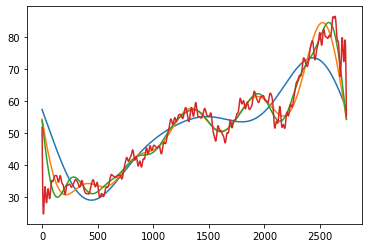

In [94]:
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))

In [95]:
fft_list_3 = np.copy(fft_list); fft_list_3[3:-3]=0

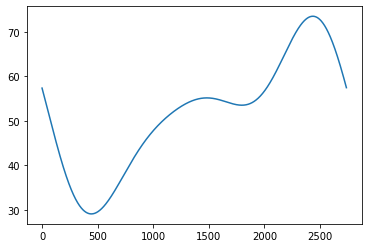

In [96]:
plt.plot(np.fft.ifft(fft_list_3), label='Fourier transform with {} components'.format(3))

In [97]:
dataset_total['FT3'] = np.fft.ifft(fft_list_3).real

In [98]:
fft_list_6 = np.copy(fft_list); fft_list_6[6:-6]=0
dataset_total['FT6'] = np.fft.ifft(fft_list_6).real

In [99]:
fft_list_9 = np.copy(fft_list); fft_list_9[9:-9]=0
dataset_total['FT9'] = np.fft.ifft(fft_list_9).real

In [100]:
dataset_total

,Date,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,...,SNY,GSK,LLY,NVS,NYSE,NASDAQ,FT,FT3,FT6,FT9
0,2009-07-27,29.694656,29.751907,29.026718,29.360687,18.955816,21026758,NaN,NaN,29.360687,...,20.185129,19.793093,23.153374,25.531801,6364.660156,1967.890015,51.727455,57.350007,54.380491,53.938574
1,2009-07-28,29.303434,29.494274,28.406488,28.645039,18.493778,23627265,NaN,NaN,28.989101,...,20.535158,19.813578,23.100662,25.589668,6328.669922,1975.510010,48.146306,57.256231,54.174474,53.631444
2,2009-07-29,28.635496,28.759542,28.158398,28.501907,18.401367,16696736,NaN,NaN,28.814057,...,20.258821,19.897017,22.988689,25.248241,6280.569824,1967.760010,44.639349,57.162340,53.968789,53.324847
3,2009-07-30,28.826336,29.551527,28.511450,28.568703,18.444492,24300290,NaN,NaN,28.745466,...,20.172846,19.917744,23.087498,25.815359,6384.310059,1984.300049,41.274057,57.068337,53.763447,53.018827
4,2009-07-31,28.816793,29.179390,28.540075,28.635496,18.487621,16269362,NaN,NaN,28.719964,...,20.043888,19.845192,22.982094,26.399841,6424.279785,1978.500000,38.113099,56.974224,53.558463,52.713429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2733,2020-06-04,77.547707,78.396950,77.137405,77.814888,73.378548,9292930,76.515814,74.863687,75.491099,...,48.132076,38.423382,146.373566,81.836136,12286.980469,9615.809570,68.335855,57.817099,55.415062,55.480641
2734,2020-06-05,78.349236,79.322517,77.757637,78.492363,74.017395,10413347,77.157852,75.097238,75.713415,...,48.276615,38.469505,144.916687,82.576424,12641.440430,9814.080078,65.403903,57.723926,55.207594,55.171523
2735,2020-06-08,77.433205,79.389313,77.433205,79.103050,74.593254,9956838,77.684024,75.428935,75.964499,...,48.960777,39.087601,144.916687,82.364914,12836.599609,9924.750000,62.216889,57.630627,55.000389,54.862711
2736,2020-06-09,79.379768,79.685112,78.358780,78.492363,74.017395,8846168,77.893947,75.695202,76.151748,...,48.999317,38.635567,144.839020,85.018433,12619.519531,9953.750000,58.831942,57.537207,54.793461,54.554253


In [101]:
dataset_total.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'ma7',
       'ma21', '26ema', '12ema', 'MACD', '20sd', 'upper_band', 'lower_band',
       'ema', 'momentum', 'log_momentum', 'pos', 'neg', 'neu', 'SNP', 'PFE',
       'JNJ', 'BMY', 'VTRS', 'AMGN', 'VZ', 'SNY', 'GSK', 'LLY', 'NVS', 'NYSE',
       'NASDAQ', 'FT', 'FT3', 'FT6', 'FT9'],
      dtype='object')

In [102]:
dataset_total_df = dataset_total[['Date','Close', 'Volume', 'ma7',
       'ma21', '26ema', '12ema', 'MACD', '20sd', 'upper_band', 'lower_band',
       'ema', 'momentum', 'log_momentum', 'pos', 'neg', 'neu', 'SNP', 'PFE',
       'JNJ', 'BMY', 'VTRS', 'AMGN', 'VZ', 'SNY', 'GSK', 'LLY', 'NVS', 'NYSE',
       'NASDAQ', 'FT3', 'FT6', 'FT9']]

In [103]:
dataset_total_df.columns

Index(['Date', 'Close', 'Volume', 'ma7', 'ma21', '26ema', '12ema', 'MACD',
       '20sd', 'upper_band', 'lower_band', 'ema', 'momentum', 'log_momentum',
       'pos', 'neg', 'neu', 'SNP', 'PFE', 'JNJ', 'BMY', 'VTRS', 'AMGN', 'VZ',
       'SNY', 'GSK', 'LLY', 'NVS', 'NYSE', 'NASDAQ', 'FT3', 'FT6', 'FT9'],
      dtype='object')

In [104]:
dataset_total_df

,Date,Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,...,VZ,SNY,GSK,LLY,NVS,NYSE,NASDAQ,FT3,FT6,FT9
0,2009-07-27,29.360687,21026758,NaN,NaN,29.360687,29.360687,0.000000,NaN,NaN,...,16.079933,20.185129,19.793093,23.153374,25.531801,6364.660156,1967.890015,57.350007,54.380491,53.938574
1,2009-07-28,28.645039,23627265,NaN,NaN,28.989101,28.973044,-0.016056,NaN,NaN,...,16.287413,20.535158,19.813578,23.100662,25.589668,6328.669922,1975.510010,57.256231,54.174474,53.631444
2,2009-07-29,28.501907,16696736,NaN,NaN,28.814057,28.789159,-0.024897,NaN,NaN,...,16.588264,20.258821,19.897017,22.988689,25.248241,6280.569824,1967.760010,57.162340,53.968789,53.324847
3,2009-07-30,28.568703,24300290,NaN,NaN,28.745466,28.719570,-0.025897,NaN,NaN,...,16.759441,20.172846,19.917744,23.087498,25.815359,6384.310059,1984.300049,57.068337,53.763447,53.018827
4,2009-07-31,28.635496,16269362,NaN,NaN,28.719964,28.696727,-0.023237,NaN,NaN,...,16.634951,20.043888,19.845192,22.982094,26.399841,6424.279785,1978.500000,56.974224,53.558463,52.713429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2733,2020-06-04,77.814888,9292930,76.515814,74.863687,75.491099,76.046941,0.555842,1.816324,78.496336,...,52.923214,48.132076,38.423382,146.373566,81.836136,12286.980469,9615.809570,57.817099,55.415062,55.480641
2734,2020-06-05,78.492363,10413347,77.157852,75.097238,75.713415,76.423160,0.709745,1.857931,78.813100,...,53.404163,48.276615,38.469505,144.916687,82.576424,12641.440430,9814.080078,57.723926,55.207594,55.171523
2735,2020-06-08,79.103050,9956838,77.684024,75.428935,75.964499,76.835451,0.870952,1.960788,79.350511,...,53.727886,48.960777,39.087601,144.916687,82.364914,12836.599609,9924.750000,57.630627,55.000389,54.862711
2736,2020-06-09,78.492363,8846168,77.893947,75.695202,76.151748,77.090360,0.938612,2.043482,79.782166,...,53.515152,48.999317,38.635567,144.839020,85.018433,12619.519531,9953.750000,57.537207,54.793461,54.554253


In [105]:
dataset_total_X = dataset_total_df[['Volume', 'ma7',
       'ma21', '26ema', '12ema', 'MACD', '20sd', 'upper_band', 'lower_band',
       'ema', 'momentum', 'log_momentum', 'pos', 'neg', 'neu', 'SNP', 'PFE',
       'JNJ', 'BMY', 'VTRS', 'AMGN', 'VZ', 'SNY', 'GSK', 'LLY', 'NVS', 'NYSE',
       'NASDAQ', 'FT3', 'FT6', 'FT9']]

dataset_total_Y = dataset_total_df[['Close']]

In [106]:
np.array(dataset_total_X)

array([[2.10267580e+07,            nan,            nan, ...,
        5.73500068e+01, 5.43804906e+01, 5.39385739e+01],
       [2.36272650e+07,            nan,            nan, ...,
        5.72562309e+01, 5.41744745e+01, 5.36314438e+01],
       [1.66967360e+07,            nan,            nan, ...,
        5.71623405e+01, 5.39687890e+01, 5.33248465e+01],
       ...,
       [9.95683800e+06, 7.76840241e+01, 7.54289355e+01, ...,
        5.76306274e+01, 5.50003889e+01, 5.48627114e+01],
       [8.84616800e+06, 7.78939470e+01, 7.56952021e+01, ...,
        5.75372070e+01, 5.47934612e+01, 5.45542527e+01],
       [9.08092000e+06, 7.81952013e+01, 7.58705928e+01, ...,
        5.74436661e+01, 5.45868239e+01, 5.42461918e+01]])

In [107]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [108]:
size = int(len(dataset_total_df) * 0.67)
trainX, testX = dataset_total_X[0:size], dataset_total_X[size:len(dataset_total_df)]
trainY, testY = dataset_total_Y[0:size], dataset_total_Y[size:len(dataset_total_df)]

In [109]:
trainX

,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,...,VZ,SNY,GSK,LLY,NVS,NYSE,NASDAQ,FT3,FT6,FT9
0,21026758,NaN,NaN,29.360687,29.360687,0.000000,NaN,NaN,NaN,29.360687,...,16.079933,20.185129,19.793093,23.153374,25.531801,6364.660156,1967.890015,57.350007,54.380491,53.938574
1,23627265,NaN,NaN,28.989101,28.973044,-0.016056,NaN,NaN,NaN,28.823951,...,16.287413,20.535158,19.813578,23.100662,25.589668,6328.669922,1975.510010,57.256231,54.174474,53.631444
2,16696736,NaN,NaN,28.814057,28.789159,-0.024897,NaN,NaN,NaN,28.600997,...,16.588264,20.258821,19.897017,22.988689,25.248241,6280.569824,1967.760010,57.162340,53.968789,53.324847
3,24300290,NaN,NaN,28.745466,28.719570,-0.025897,NaN,NaN,NaN,28.579199,...,16.759441,20.172846,19.917744,23.087498,25.815359,6384.310059,1984.300049,57.068337,53.763447,53.018827
4,16269362,NaN,NaN,28.719964,28.696727,-0.023237,NaN,NaN,NaN,28.616885,...,16.634951,20.043888,19.845192,22.982094,26.399841,6424.279785,1978.500000,56.974224,53.558463,52.713429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1829,21335603,58.181570,59.072155,58.886351,58.397833,-0.488518,0.981870,61.035895,57.108415,56.906506,...,38.136497,31.927320,30.528387,66.199387,53.269310,10476.620117,5190.100098,53.569388,58.697379,58.608059
1830,14939030,57.745365,58.904489,58.674809,58.033633,-0.641176,1.178673,61.261835,56.547143,56.322524,...,38.049480,31.968420,30.429516,65.586502,53.231834,10481.889648,5189.140137,53.573552,58.743025,58.658565
1831,15036075,57.486368,58.758178,58.519932,57.810608,-0.709324,1.269416,61.297011,56.219346,56.496821,...,37.701424,32.083500,30.307840,64.822632,53.479179,10414.049805,5153.580078,53.577855,58.788413,58.708989
1832,11239486,57.226008,58.593693,58.344014,57.554367,-0.789647,1.358315,61.310322,55.877063,56.262300,...,37.131851,32.675362,30.387871,64.529518,53.411716,10334.500000,5105.569824,53.582297,58.833537,58.759328


In [110]:
testX

,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,...,VZ,SNY,GSK,LLY,NVS,NYSE,NASDAQ,FT3,FT6,FT9
1834,11861893,56.466739,58.220647,58.002059,57.100220,-0.901839,1.486800,61.194246,55.247047,56.058407,...,37.242607,32.831539,29.726091,64.387390,52.654694,10289.349609,5046.370117,53.591603,58.922978,58.859728
1835,10981258,56.297710,58.097055,57.950026,57.130897,-0.819130,1.337363,60.771782,55.422328,56.885881,...,37.543209,32.576717,29.887686,65.622032,53.141888,10500.160156,5166.169922,53.596468,58.967285,58.909781
1836,8323321,56.525354,57.943020,57.934361,57.224381,-0.709980,1.310612,60.564244,55.321797,57.454326,...,37.693508,33.012390,30.118542,65.746376,53.426712,10530.559570,5193.490234,53.601475,59.011312,58.959728
1837,29187953,57.269629,58.045256,58.179257,57.842240,-0.337018,1.499119,61.043495,55.047017,59.978415,...,37.859627,34.533127,31.088121,69.627937,55.682804,10643.410156,5251.069824,53.606624,59.055055,59.009566
1838,18719690,58.041167,58.195201,58.461145,58.479546,0.018402,1.710116,61.615434,54.774969,61.315961,...,36.934101,34.385162,30.703363,70.039185,55.517914,10683.410156,5208.799805,53.611918,59.098508,59.059288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2733,9292930,76.515814,74.863687,75.491099,76.046941,0.555842,1.816324,78.496336,71.231038,77.807402,...,52.923214,48.132076,38.423382,146.373566,81.836136,12286.980469,9615.809570,57.817099,55.415062,55.480641
2734,10413347,77.157852,75.097238,75.713415,76.423160,0.709745,1.857931,78.813100,71.381377,78.264043,...,53.404163,48.276615,38.469505,144.916687,82.576424,12641.440430,9814.080078,57.723926,55.207594,55.171523
2735,9956838,77.684024,75.428935,75.964499,76.835451,0.870952,1.960788,79.350511,71.507360,78.823381,...,53.727886,48.960777,39.087601,144.916687,82.364914,12836.599609,9924.750000,57.630627,55.000389,54.862711
2736,8846168,77.893947,75.695202,76.151748,77.090360,0.938612,2.043482,79.782166,71.608238,78.602702,...,53.515152,48.999317,38.635567,144.839020,85.018433,12619.519531,9953.750000,57.537207,54.793461,54.554253


In [111]:
trainY

,Close
0,29.360687
1,28.645039
2,28.501907
3,28.568703
4,28.635496
...,...
1829,56.145039
1830,56.030533
1831,56.583969
1832,56.145039


In [112]:
dataset_total_df

,Date,Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,...,VZ,SNY,GSK,LLY,NVS,NYSE,NASDAQ,FT3,FT6,FT9
0,2009-07-27,29.360687,21026758,NaN,NaN,29.360687,29.360687,0.000000,NaN,NaN,...,16.079933,20.185129,19.793093,23.153374,25.531801,6364.660156,1967.890015,57.350007,54.380491,53.938574
1,2009-07-28,28.645039,23627265,NaN,NaN,28.989101,28.973044,-0.016056,NaN,NaN,...,16.287413,20.535158,19.813578,23.100662,25.589668,6328.669922,1975.510010,57.256231,54.174474,53.631444
2,2009-07-29,28.501907,16696736,NaN,NaN,28.814057,28.789159,-0.024897,NaN,NaN,...,16.588264,20.258821,19.897017,22.988689,25.248241,6280.569824,1967.760010,57.162340,53.968789,53.324847
3,2009-07-30,28.568703,24300290,NaN,NaN,28.745466,28.719570,-0.025897,NaN,NaN,...,16.759441,20.172846,19.917744,23.087498,25.815359,6384.310059,1984.300049,57.068337,53.763447,53.018827
4,2009-07-31,28.635496,16269362,NaN,NaN,28.719964,28.696727,-0.023237,NaN,NaN,...,16.634951,20.043888,19.845192,22.982094,26.399841,6424.279785,1978.500000,56.974224,53.558463,52.713429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2733,2020-06-04,77.814888,9292930,76.515814,74.863687,75.491099,76.046941,0.555842,1.816324,78.496336,...,52.923214,48.132076,38.423382,146.373566,81.836136,12286.980469,9615.809570,57.817099,55.415062,55.480641
2734,2020-06-05,78.492363,10413347,77.157852,75.097238,75.713415,76.423160,0.709745,1.857931,78.813100,...,53.404163,48.276615,38.469505,144.916687,82.576424,12641.440430,9814.080078,57.723926,55.207594,55.171523
2735,2020-06-08,79.103050,9956838,77.684024,75.428935,75.964499,76.835451,0.870952,1.960788,79.350511,...,53.727886,48.960777,39.087601,144.916687,82.364914,12836.599609,9924.750000,57.630627,55.000389,54.862711
2736,2020-06-09,78.492363,8846168,77.893947,75.695202,76.151748,77.090360,0.938612,2.043482,79.782166,...,53.515152,48.999317,38.635567,144.839020,85.018433,12619.519531,9953.750000,57.537207,54.793461,54.554253


In [113]:
is_NaN = dataset_total_df.isnull()
row_has_NaN = is_NaN.any(axis=1)
dataset_total_df_clean = dataset_total_df[-row_has_NaN]

In [114]:
dataset_total_df_clean

,Date,Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,...,VZ,SNY,GSK,LLY,NVS,NYSE,NASDAQ,FT3,FT6,FT9
20,2009-08-24,31.011450,14227229,30.050436,29.200291,29.514006,29.867322,0.353316,0.835852,30.871996,...,16.292601,20.842203,20.441223,22.546118,26.214659,6671.140137,2017.979980,55.454947,50.337802,47.947327
21,2009-08-25,31.440840,20081566,30.318975,29.299346,29.688906,30.115697,0.426791,0.963549,31.226444,...,16.240730,20.854488,20.290916,22.639704,26.532936,6697.220215,2024.229980,55.359252,50.140845,47.659130
22,2009-08-26,31.183207,10438080,30.564340,29.420211,29.822316,30.283528,0.461212,1.026446,31.473102,...,16.328911,20.866764,20.280560,22.492651,26.608166,6687.939941,2024.430054,55.263482,49.944470,47.372320
23,2009-08-27,31.364504,10302154,30.858779,29.556525,29.957940,30.452906,0.494965,1.086420,31.729366,...,16.105865,21.014151,20.513781,22.800129,26.984312,6722.310059,2027.729980,55.167638,49.748691,47.086936
24,2009-08-28,30.839695,12640452,30.973283,29.664667,30.034423,30.513340,0.478916,1.094567,31.853801,...,16.090305,21.204517,20.285738,22.459229,26.857002,6709.040039,2028.770020,55.071723,49.553518,46.803017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2733,2020-06-04,77.814888,9292930,76.515814,74.863687,75.491099,76.046941,0.555842,1.816324,78.496336,...,52.923214,48.132076,38.423382,146.373566,81.836136,12286.980469,9615.809570,57.817099,55.415062,55.480641
2734,2020-06-05,78.492363,10413347,77.157852,75.097238,75.713415,76.423160,0.709745,1.857931,78.813100,...,53.404163,48.276615,38.469505,144.916687,82.576424,12641.440430,9814.080078,57.723926,55.207594,55.171523
2735,2020-06-08,79.103050,9956838,77.684024,75.428935,75.964499,76.835451,0.870952,1.960788,79.350511,...,53.727886,48.960777,39.087601,144.916687,82.364914,12836.599609,9924.750000,57.630627,55.000389,54.862711
2736,2020-06-09,78.492363,8846168,77.893947,75.695202,76.151748,77.090360,0.938612,2.043482,79.782166,...,53.515152,48.999317,38.635567,144.839020,85.018433,12619.519531,9953.750000,57.537207,54.793461,54.554253


In [115]:
target_sensor = "Close"
features = list(dataset_total_df_clean.columns.difference([target_sensor]))

forecast_lead = 1
target = f"{target_sensor}_lead{forecast_lead}"

dataset_total_df_clean[target] = dataset_total_df_clean[target_sensor].shift(-forecast_lead)
dataset_total_df_clean = dataset_total_df_clean.iloc[:-forecast_lead]

In [116]:
dataset_total_df

,Date,Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,...,VZ,SNY,GSK,LLY,NVS,NYSE,NASDAQ,FT3,FT6,FT9
0,2009-07-27,29.360687,21026758,NaN,NaN,29.360687,29.360687,0.000000,NaN,NaN,...,16.079933,20.185129,19.793093,23.153374,25.531801,6364.660156,1967.890015,57.350007,54.380491,53.938574
1,2009-07-28,28.645039,23627265,NaN,NaN,28.989101,28.973044,-0.016056,NaN,NaN,...,16.287413,20.535158,19.813578,23.100662,25.589668,6328.669922,1975.510010,57.256231,54.174474,53.631444
2,2009-07-29,28.501907,16696736,NaN,NaN,28.814057,28.789159,-0.024897,NaN,NaN,...,16.588264,20.258821,19.897017,22.988689,25.248241,6280.569824,1967.760010,57.162340,53.968789,53.324847
3,2009-07-30,28.568703,24300290,NaN,NaN,28.745466,28.719570,-0.025897,NaN,NaN,...,16.759441,20.172846,19.917744,23.087498,25.815359,6384.310059,1984.300049,57.068337,53.763447,53.018827
4,2009-07-31,28.635496,16269362,NaN,NaN,28.719964,28.696727,-0.023237,NaN,NaN,...,16.634951,20.043888,19.845192,22.982094,26.399841,6424.279785,1978.500000,56.974224,53.558463,52.713429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2733,2020-06-04,77.814888,9292930,76.515814,74.863687,75.491099,76.046941,0.555842,1.816324,78.496336,...,52.923214,48.132076,38.423382,146.373566,81.836136,12286.980469,9615.809570,57.817099,55.415062,55.480641
2734,2020-06-05,78.492363,10413347,77.157852,75.097238,75.713415,76.423160,0.709745,1.857931,78.813100,...,53.404163,48.276615,38.469505,144.916687,82.576424,12641.440430,9814.080078,57.723926,55.207594,55.171523
2735,2020-06-08,79.103050,9956838,77.684024,75.428935,75.964499,76.835451,0.870952,1.960788,79.350511,...,53.727886,48.960777,39.087601,144.916687,82.364914,12836.599609,9924.750000,57.630627,55.000389,54.862711
2736,2020-06-09,78.492363,8846168,77.893947,75.695202,76.151748,77.090360,0.938612,2.043482,79.782166,...,53.515152,48.999317,38.635567,144.839020,85.018433,12619.519531,9953.750000,57.537207,54.793461,54.554253


In [117]:
features = list(dataset_total_df_clean.columns.difference([target_sensor, 'Close_lead1', 'Date']))
features

['12ema',
 '20sd',
 '26ema',
 'AMGN',
 'BMY',
 'FT3',
 'FT6',
 'FT9',
 'GSK',
 'JNJ',
 'LLY',
 'MACD',
 'NASDAQ',
 'NVS',
 'NYSE',
 'PFE',
 'SNP',
 'SNY',
 'VTRS',
 'VZ',
 'Volume',
 'ema',
 'log_momentum',
 'lower_band',
 'ma21',
 'ma7',
 'momentum',
 'neg',
 'neu',
 'pos',
 'upper_band']

In [118]:
size = int(len(dataset_total_df_clean) * 0.67)

df_train = dataset_total_df_clean.loc[:size].copy()
df_test = dataset_total_df_clean.loc[size:].copy()

In [119]:
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

In [120]:
df_train

,Date,Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,...,SNY,GSK,LLY,NVS,NYSE,NASDAQ,FT3,FT6,FT9,Close_lead1
20,-1.728704,-1.360762,0.007753,-1.460784,-1.544621,-1.512489,-1.479687,0.474498,0.011460,-1.497728,...,-1.418072,-1.530400,-1.214332,-1.514771,-1.622833,-1.500633,1.125855,0.684865,0.438936,-1.316618
21,-1.727379,-1.315251,0.798828,-1.432258,-1.534056,-1.493765,-1.453231,0.622193,0.306570,-1.461046,...,-1.416347,-1.561388,-1.208852,-1.492504,-1.604843,-1.494578,1.115617,0.663200,0.407470,-1.343918
22,-1.726055,-1.342557,-0.504260,-1.406193,-1.521165,-1.479482,-1.435355,0.691384,0.451926,-1.435520,...,-1.414623,-1.563523,-1.217463,-1.487241,-1.611245,-1.494385,1.105370,0.641599,0.376156,-1.324707
23,-1.724730,-1.323342,-0.522627,-1.374915,-1.506626,-1.464963,-1.417314,0.759233,0.590529,-1.409000,...,-1.393928,-1.515441,-1.199457,-1.460926,-1.587535,-1.491188,1.095116,0.620064,0.344998,-1.380318
24,-1.723406,-1.378966,-0.206662,-1.362751,-1.495092,-1.456775,-1.410877,0.726972,0.609355,-1.396122,...,-1.367198,-1.562456,-1.219420,-1.469832,-1.596689,-1.490180,1.084854,0.598595,0.313999,-1.369196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1816,1.721572,1.615641,0.061538,1.704518,1.695123,1.714499,1.706987,0.022082,-0.565852,1.594109,...,0.066871,0.862843,1.720605,0.678968,1.051519,1.627308,0.919647,1.536752,1.530608,1.586318
1817,1.722897,1.588335,-0.481333,1.692065,1.694396,1.707989,1.691434,-0.149204,-0.623905,1.588205,...,0.035707,0.853434,1.652989,0.655896,1.059982,1.619781,0.919906,1.542099,1.536196,1.672263
1818,1.724221,1.674300,0.144537,1.692789,1.700018,1.708394,1.691565,-0.154331,-0.624951,1.593566,...,0.010314,0.902042,1.626461,0.676347,1.034232,1.594894,0.920179,1.547424,1.541781,1.634852
1819,1.725546,1.636880,-0.186454,1.683232,1.698855,1.705969,1.685890,-0.215889,-0.617352,1.593118,...,0.012622,0.790714,1.588492,0.641214,1.033100,1.595698,0.920466,1.552727,1.547362,1.572162


In [121]:
df_test

,Date,Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,...,SNY,GSK,LLY,NVS,NYSE,NASDAQ,FT3,FT6,FT9,Close_lead1
1820,1.729519,1.574176,-0.066027,1.666724,1.695172,1.699032,1.671394,-0.359208,-0.657602,1.585939,...,-0.033547,0.713883,1.550002,0.614471,1.013482,1.581805,0.920767,1.558006,1.552939,1.629796
1821,1.730844,1.631823,-0.500295,1.656877,1.698855,1.696922,1.668041,-0.382874,-0.672290,1.588198,...,0.010314,0.803258,1.562485,0.652750,1.065184,1.624450,0.921082,1.563262,1.558511,1.607552
1822,1.732168,1.609573,-1.124140,1.627481,1.698515,1.693304,1.661764,-0.433400,-0.639816,1.590777,...,-0.013926,0.760921,1.551562,0.618141,1.088024,1.626940,0.921412,1.568493,1.564080,1.612607
1823,1.733493,1.614630,-1.019248,1.627337,1.694735,1.690332,1.657234,-0.463083,-0.648642,1.586319,...,0.049558,0.751513,1.560924,0.632299,1.085568,1.622503,0.921756,1.573700,1.569643,1.539806
1824,1.734817,1.541813,-0.865839,1.620676,1.685915,1.682132,1.642143,-0.593914,-0.553541,1.586278,...,0.012622,0.704475,1.535439,0.612373,1.067991,1.637587,0.922114,1.578882,1.575200,1.494306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2732,3.484458,3.651489,-0.066806,3.413078,3.308477,3.389777,3.404890,0.609146,2.020527,3.391193,...,2.363745,2.266319,6.140358,2.415529,2.261602,5.924843,1.388534,1.266199,1.295211,3.597443
2733,3.485783,3.599910,-0.659000,3.475199,3.325633,3.409679,3.439128,0.881603,2.277357,3.430841,...,2.413808,2.176927,6.036849,2.376518,2.251109,5.859839,1.378579,1.243351,1.261432,3.669232
2734,3.487107,3.671715,-0.507602,3.543402,3.350542,3.433480,3.479201,1.190969,2.373511,3.463623,...,2.434103,2.186436,5.951536,2.428309,2.495624,6.051915,1.368610,1.220530,1.227682,3.733944
2735,3.491081,3.736442,-0.569289,3.599297,3.385919,3.460360,3.523116,1.515017,2.611215,3.519238,...,2.530169,2.313867,5.951536,2.413511,2.630250,6.159128,1.358628,1.197738,1.193966,3.669232


## Process Data

We process the data above into a form where the time series is implied, so that we can run the multi-input LSTM.

In [122]:
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[self.target].values).float()
        self.X = torch.tensor(dataframe[self.features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [123]:
i = 1
sequence_length = 4

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)

X, y = train_dataset[i]
print(X)

tensor([[-1.4797,  0.0115, -1.5125, -0.9790, -1.3147,  1.1259,  0.6849,  0.4389,
         -1.5304, -1.1762, -1.2143,  0.4745, -1.5006, -1.5148, -1.6228, -1.4108,
         -1.5342, -1.4181, -1.3084, -1.6163,  0.0078, -1.3729, -1.4831, -1.5818,
         -1.5446, -1.4608, -1.3608, -0.4157,  0.7072, -0.5917, -1.4977],
        [-1.4797,  0.0115, -1.5125, -0.9790, -1.3147,  1.1259,  0.6849,  0.4389,
         -1.5304, -1.1762, -1.2143,  0.4745, -1.5006, -1.5148, -1.6228, -1.4108,
         -1.5342, -1.4181, -1.3084, -1.6163,  0.0078, -1.3729, -1.4831, -1.5818,
         -1.5446, -1.4608, -1.3608, -0.4157,  0.7072, -0.5917, -1.4977],
        [-1.4797,  0.0115, -1.5125, -0.9790, -1.3147,  1.1259,  0.6849,  0.4389,
         -1.5304, -1.1762, -1.2143,  0.4745, -1.5006, -1.5148, -1.6228, -1.4108,
         -1.5342, -1.4181, -1.3084, -1.6163,  0.0078, -1.3729, -1.4831, -1.5818,
         -1.5446, -1.4608, -1.3608, -0.4157,  0.7072, -0.5917, -1.4977],
        [-1.4532,  0.3066, -1.4938, -0.9795, -1.2979

In [124]:
from torch.utils.data import DataLoader
torch.manual_seed(99)

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)

X, y = next(iter(train_loader))
print(X.shape)
print(X)

torch.Size([3, 4, 31])
tensor([[[-1.4354e+00,  4.5193e-01, -1.4795e+00, -9.6108e-01, -1.2997e+00,
           1.1054e+00,  6.4160e-01,  3.7616e-01, -1.5635e+00, -1.1994e+00,
          -1.2175e+00,  6.9138e-01, -1.4944e+00, -1.4872e+00, -1.6112e+00,
          -1.4066e+00, -1.5274e+00, -1.4146e+00, -1.3143e+00, -1.6117e+00,
          -5.0426e-01, -1.3400e+00, -1.4576e+00, -1.5994e+00, -1.5212e+00,
          -1.4062e+00, -1.3426e+00, -4.1571e-01,  7.0724e-01, -5.9167e-01,
          -1.4355e+00],
         [-1.4173e+00,  5.9053e-01, -1.4650e+00, -9.8176e-01, -1.3056e+00,
           1.0951e+00,  6.2006e-01,  3.4500e-01, -1.5154e+00, -1.2044e+00,
          -1.1995e+00,  7.5923e-01, -1.4912e+00, -1.4609e+00, -1.5875e+00,
          -1.3972e+00, -1.5198e+00, -1.3939e+00, -1.2921e+00, -1.6400e+00,
          -5.2263e-01, -1.3290e+00, -1.4308e+00, -1.5976e+00, -1.5066e+00,
          -1.3749e+00, -1.3233e+00, -4.1571e-01,  7.0724e-01, -5.9167e-01,
          -1.4090e+00],
         [-1.4109e+00,  6.093

In [214]:
torch.manual_seed(101)

batch_size = 4
sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([4, 3, 31])
Target shape: torch.Size([4])


# Building an LSTM

We use the inbuilt LSTM in order to run the modelling, and then show the results of the prediction.

Optimizer: ADAM, with lr 0.00005

Loss: MSELoss

In [215]:
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out


In [216]:
learning_rate = 5e-5
num_hidden_units = 16

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [217]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")

In [218]:
print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

for ix_epoch in range(200):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(test_loader, model, loss_function)
    print()

Untrained test
--------
Test loss: 7.431167671213979

Epoch 0
---------
Train loss: 0.8453788959861066
Test loss: 5.8647354192059975

Epoch 1
---------
Train loss: 0.42218187073051533
Test loss: 4.5544535294499084

Epoch 2
---------
Train loss: 0.1799335241082337
Test loss: 3.5478486847223554

Epoch 3
---------
Train loss: 0.08638890612944795
Test loss: 3.0240885258263797

Epoch 4
---------
Train loss: 0.0576179300996572
Test loss: 2.723245865809124

Epoch 5
---------
Train loss: 0.04486869800471372
Test loss: 2.5764221074026707

Epoch 6
---------
Train loss: 0.036250491613460736
Test loss: 2.5379642973452143

Epoch 7
---------
Train loss: 0.02952442456144187
Test loss: 2.5079005505596084

Epoch 8
---------
Train loss: 0.024440998336823734
Test loss: 2.37032207781449

Epoch 9
---------
Train loss: 0.020519836510657054
Test loss: 2.2816395257032758

Epoch 10
---------
Train loss: 0.01768150207275027
Test loss: 2.2051968487050466

Epoch 11
---------
Train loss: 0.015538434137505306
Test 

Train loss: 0.004128710224347766
Test loss: 1.0635571604913465

Epoch 100
---------
Train loss: 0.0041168447244202405
Test loss: 1.0581370895113493

Epoch 101
---------
Train loss: 0.004076507333638323
Test loss: 1.0521669792515635

Epoch 102
---------
Train loss: 0.004064217736270232
Test loss: 1.0497925009140643

Epoch 103
---------
Train loss: 0.004110565876580869
Test loss: 1.0369388318203046

Epoch 104
---------
Train loss: 0.004036733887624641
Test loss: 1.0532629867552517

Epoch 105
---------
Train loss: 0.00403203496041175
Test loss: 1.0458231860045444

Epoch 106
---------
Train loss: 0.00402962383762208
Test loss: 1.0193431212549078

Epoch 107
---------
Train loss: 0.003968992312862115
Test loss: 1.0319217387438782

Epoch 108
---------
Train loss: 0.0039675124768964575
Test loss: 1.0133692685431173

Epoch 109
---------
Train loss: 0.0039624172764130255
Test loss: 1.0367143231311196

Epoch 110
---------
Train loss: 0.003943983607451424
Test loss: 1.0286893170439568

Epoch 111
-

Train loss: 0.0032754046974746
Test loss: 0.8594683330807248

Epoch 198
---------
Train loss: 0.003264505868796863
Test loss: 0.871125924291656

Epoch 199
---------
Train loss: 0.0032518396751352167
Test loss: 0.8491045705507175



In [219]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.templates.default = "plotly_white"

plot_template = dict(
    layout=go.Layout({
        "font_size": 18,
        "xaxis_title_font_size": 24,
        "yaxis_title_font_size": 24})
)

In [220]:
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

In [221]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

      Close_lead1  Model forecast
20      31.440840       30.941822
21      31.183207       31.165440
22      31.364504       31.115080
23      30.839695       31.154144
24      30.944656       30.973114
...           ...             ...
2732    77.814888       65.763199
2733    78.492363       65.764221
2734    79.103050       65.890060
2735    78.492363       66.337891
2736    78.024811       66.117310

[2718 rows x 2 columns]


In [222]:
fig = px.line(df_out, labels={'value': "PM2.5 (ug/m3)", 'created_at': 'Date'})
#fig.add_vline(x=test_start, line_width=4, line_dash="dash")
fig.add_annotation(xref="paper", x=0.75, yref="paper", y=0.8, text="Test set start", showarrow=False)
fig.update_layout(
  template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
)
fig.show()
fig.write_image("pm25_forecast.png", width=1200, height=600)

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


# QLSTM

We build our own QLSTM module to run the analysis

In [223]:
import torch
import torch.nn as nn

import pennylane as qml

In [ ]:
class QLSTM(nn.Module):
    def __init__(self, 
                input_size, 
                hidden_size, 
                n_qubits=4,
                n_qlayers=1,
                batch_first=True,
                return_sequences=False, 
                return_state=False,
                backend="default.qubit"):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state

        #self.dev = qml.device("default.qubit", wires=self.n_qubits)
        #self.dev = qml.device('qiskit.basicaer', wires=self.n_qubits)
        #self.dev = qml.device('qiskit.ibm', wires=self.n_qubits)
        # use 'qiskit.ibmq' instead to run on hardware

        self.wires_forget = [f"wire_forget_{i}" for i in range(self.n_qubits)]
        self.wires_input = [f"wire_input_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        self.wires_output = [f"wire_output_{i}" for i in range(self.n_qubits)]

        self.dev_forget = qml.device(self.backend, wires=self.wires_forget)
        self.dev_input = qml.device(self.backend, wires=self.wires_input)
        self.dev_update = qml.device(self.backend, wires=self.wires_update)
        self.dev_output = qml.device(self.backend, wires=self.wires_output)

        def _circuit_forget(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_forget)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_forget]
        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch")

        def _circuit_input(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_input)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_input)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_input]
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch")

        def _circuit_update(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_update)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_update)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_update]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")

        def _circuit_output(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_output)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_output)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output]
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch")

        weight_shapes = {"weights": (n_qlayers, n_qubits)}
        print(f"weight_shapes = (n_qlayers, n_qubits) = ({n_qlayers}, {n_qubits})")

        self.clayer_in = torch.nn.Linear(self.concat_size, n_qubits)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)
        #self.clayer_out = [torch.nn.Linear(n_qubits, self.hidden_size) for _ in range(4)]

    def forward(self, x, init_states=None):
        '''
        x.shape is (batch_size, seq_length, feature_size)
        recurrent_activation -> sigmoid
        activation -> tanh
        '''
        if self.batch_first is True:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size, features_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)  # hidden state (output)
            c_t = torch.zeros(batch_size, self.hidden_size)  # cell state
        else:
            # for now we ignore the fact that in PyTorch you can stack multiple RNNs
            # so we take only the first elements of the init_states tuple init_states[0][0], init_states[1][0]
            h_t, c_t = init_states
            h_t = h_t[0]
            c_t = c_t[0]

        for t in range(seq_length):
            # get features from the t-th element in seq, for all entries in the batch
            x_t = x[:, t, :]
            
            # Concatenate input and hidden state
            v_t = torch.cat((h_t, x_t), dim=1)

            # match qubit dimension
            y_t = self.clayer_in(v_t)

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](y_t)))  # forget block
            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](y_t)))  # input block
            g_t = torch.tanh(self.clayer_out(self.VQC['update'](y_t)))  # update block
            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](y_t))) # output block

            c_t = (f_t * c_t) + (i_t * g_t)
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

In [206]:
class QLSTM(nn.Module):
    def __init__(self, 
                input_size, 
                hidden_size, 
                n_qubits=4,
                n_qlayers=1,
                n_vrotations=3,
                batch_first=True,
                return_sequences=False, 
                return_state=False,
                backend="default.qubit"):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.n_vrotations = n_vrotations
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state

        self.dev_forget = qml.device(self.backend, wires=self.n_qubits)
        self.dev_input = qml.device(self.backend, wires=self.n_qubits)
        self.dev_update = qml.device(self.backend, wires=self.n_qubits)
        self.dev_output = qml.device(self.backend, wires=self.n_qubits)
        
        def ansatz(params):
            # Entangling layer.
            for i in range(1,3): 
                for j in range(self.n_qubits):
                    if j + i < self.n_qubits:
                        qml.CNOT(wires=[j, j + i])
                    else:
                        qml.CNOT(wires=[j, j + i - self.n_qubits])

            # Variational layer.
            for i in range(self.n_qubits):
                qml.RX(params[0][i], wires=i)
                qml.RY(params[1][i], wires=i)
                qml.RZ(params[2][i], wires=i)
                
        def VQC(features, weights):
            # Preproccess input data to encode the initial state.
            ry_params = [np.arctan(features) for feature in features]
            rz_params = [np.arctan(features**2) for feature in features]
            for i in range(self.n_qubits):
                qml.Hadamard(wires=i)
                qml.RY(ry_params[i], wires=i)
                qml.RZ(rz_params[i], wires=i)
        
            #Variational block.
            qml.layer(ansatz, self.n_qlayers, weights)

            return [qml.expval(qml.PauliZ(wires=i)) for i in range(self.n_qubits)]

        def _circuit_forget(inputs, weights):
            VQC(inputs, weights)
        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch")

        def _circuit_input(inputs, weights):
            VQC(inputs, weights)
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch")

        def _circuit_update(inputs, weights):
            VQC(inputs, weights)
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")

        def _circuit_output(inputs, weights):
            VQC(inputs, weights)
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch")

        weight_shapes = {"weights": (self.n_qlayers, self.n_vrotations, self.n_qubits)}
        print(f"weight_shapes = (n_qlayers, n_vrotations, n_qubits) = ({self.n_qlayers}, {self.n_vrotations}, {self.n_qubits})")

        self.clayer_in = torch.nn.Linear(self.concat_size, self.n_qubits)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)
        #self.clayer_out = [torch.nn.Linear(n_qubits, self.hidden_size) for _ in range(4)]

    def forward(self, x, init_states=None):
        '''
        x.shape is (batch_size, seq_length, feature_size)
        recurrent_activation -> sigmoid
        activation -> tanh
        '''
        if self.batch_first is True:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size, features_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)  # hidden state (output)
            c_t = torch.zeros(batch_size, self.hidden_size)  # cell state
        else:
            # for now we ignore the fact that in PyTorch you can stack multiple RNNs
            # so we take only the first elements of the init_states tuple init_states[0][0], init_states[1][0]
            h_t, c_t = init_states
            h_t = h_t[0]
            c_t = c_t[0]

        for t in range(seq_length):
            # get features from the t-th element in seq, for all entries in the batch
            x_t = x[:, t, :]
            
            # Concatenate input and hidden state
            v_t = torch.cat((h_t, x_t), dim=1)

            # match qubit dimension
            y_t = self.clayer_in(v_t)

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](y_t)))  # forget block
            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](y_t)))  # input block
            g_t = torch.tanh(self.clayer_out(self.VQC['update'](y_t)))  # update block
            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](y_t))) # output block

            c_t = (f_t * c_t) + (i_t * g_t)
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

In [228]:
class QLSTM(nn.Module):
    def __init__(self, 
                input_size, 
                hidden_size, 
                n_qubits=4,
                n_qlayers=1,
                n_vrotations=3,
                batch_first=True,
                return_sequences=False, 
                return_state=False,
                backend="default.qubit"):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.n_vrotations = n_vrotations
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state
        
        self.wires_forget = [f"wire_forget_{i}" for i in range(self.n_qubits)]
        self.wires_input = [f"wire_input_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        self.wires_output = [f"wire_output_{i}" for i in range(self.n_qubits)]

        self.dev_forget = qml.device(self.backend, wires=self.wires_forget)
        self.dev_input = qml.device(self.backend, wires=self.wires_input)
        self.dev_update = qml.device(self.backend, wires=self.wires_update)
        self.dev_output = qml.device(self.backend, wires=self.wires_output)

        #self.dev_forget = qml.device(self.backend, wires=self.n_qubits)
        #self.dev_input = qml.device(self.backend, wires=self.n_qubits)
        #self.dev_update = qml.device(self.backend, wires=self.n_qubits)
        #self.dev_output = qml.device(self.backend, wires=self.n_qubits)
        
        def ansatz(params, wires_type):
            # Entangling layer.
            for i in range(1,3): 
                for j in range(self.n_qubits):
                    if j + i < self.n_qubits:
                        qml.CNOT(wires=[wires_type[j], wires_type[j + i]])
                    else:
                        qml.CNOT(wires=[wires_type[j], wires_type[j + i - self.n_qubits]])

            # Variational layer.
            for i in range(self.n_qubits):
                qml.RX(params[0][i], wires=wires_type[i])
                qml.RY(params[1][i], wires=wires_type[i])
                qml.RZ(params[2][i], wires=wires_type[i])
                
        def VQC(features, weights, wires_type):
            # Preproccess input data to encode the initial state.
            #qml.templates.AngleEmbedding(features, wires=wires_type)
            ry_params = [torch.arctan(feature) for feature in features]
            rz_params = [torch.arctan(feature**2) for feature in features]
            for i in range(self.n_qubits):
                qml.Hadamard(wires=wires_type[i])
                qml.RY(ry_params[i], wires=wires_type[i])
                qml.RZ(ry_params[i], wires=wires_type[i])
        
            #Variational block.
            qml.layer(ansatz, self.n_qlayers, weights, wires_type = wires_type)

        def _circuit_forget(inputs, weights):
            VQC(inputs, weights, self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=i)) for i in self.wires_forget]
        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch")

        def _circuit_input(inputs, weights):
            VQC(inputs, weights, self.wires_input)
            return [qml.expval(qml.PauliZ(wires=i)) for i in self.wires_input]
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch")

        def _circuit_update(inputs, weights):
            VQC(inputs, weights, self.wires_update)
            return [qml.expval(qml.PauliZ(wires=i)) for i in self.wires_update]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")

        def _circuit_output(inputs, weights):
            VQC(inputs, weights, self.wires_output)
            return [qml.expval(qml.PauliZ(wires=i)) for i in self.wires_output]
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch")

        weight_shapes = {"weights": (self.n_qlayers, self.n_vrotations, self.n_qubits)}
        print(f"weight_shapes = (n_qlayers, n_vrotations, n_qubits) = ({self.n_qlayers}, {self.n_vrotations}, {self.n_qubits})")

        self.clayer_in = torch.nn.Linear(self.concat_size, self.n_qubits)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)
        #self.clayer_out = [torch.nn.Linear(n_qubits, self.hidden_size) for _ in range(4)]

    def forward(self, x, init_states=None):
        '''
        x.shape is (batch_size, seq_length, feature_size)
        recurrent_activation -> sigmoid
        activation -> tanh
        '''
        if self.batch_first is True:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size, features_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)  # hidden state (output)
            c_t = torch.zeros(batch_size, self.hidden_size)  # cell state
        else:
            # for now we ignore the fact that in PyTorch you can stack multiple RNNs
            # so we take only the first elements of the init_states tuple init_states[0][0], init_states[1][0]
            h_t, c_t = init_states
            h_t = h_t[0]
            c_t = c_t[0]

        for t in range(seq_length):
            # get features from the t-th element in seq, for all entries in the batch
            x_t = x[:, t, :]
            
            # Concatenate input and hidden state
            v_t = torch.cat((h_t, x_t), dim=1)

            # match qubit dimension
            y_t = self.clayer_in(v_t)

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](y_t)))  # forget block
            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](y_t)))  # input block
            g_t = torch.tanh(self.clayer_out(self.VQC['update'](y_t)))  # update block
            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](y_t))) # output block

            c_t = (f_t * c_t) + (i_t * g_t)
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

In [229]:
class QShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units, n_qubits=0):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        #self.lstm = nn.LSTM(
        #    input_size=num_sensors,
        #    hidden_size=hidden_units,
        #    batch_first=True,
        #    num_layers=self.num_layers
        #)
        
        self.lstm = QLSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            n_qubits = n_qubits
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [230]:
learning_rate = 5e-5
num_hidden_units = 16

model = QShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units, n_qubits=4)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

weight_shapes = (n_qlayers, n_vrotations, n_qubits) = (1, 3, 4)


In [231]:
print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

for ix_epoch in range(200):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(test_loader, model, loss_function)
    print()

Untrained test
--------
Test loss: 8.39110360197399

Epoch 0
---------


KeyboardInterrupt: 

In [196]:
fs = np.array([1,1,2,3])
fs = torch.FloatTensor(fs)
ry_params = [np.arctan(f) for f in fs]

In [197]:
ry_params

[tensor(0.7854), tensor(0.7854), tensor(1.1071), tensor(1.2490)]

# Quick Experiments

## Time

In [232]:
import time

In [233]:
torch.manual_seed(101)

batch_size = 4
sequence_length = 10

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([4, 10, 31])
Target shape: torch.Size([4])


In [234]:
print("Untrained test\n--------")
start = time.time()
test_model(test_loader, model, loss_function)
end = time.time()
print("Execution time", end - start)

Untrained test
--------
Test loss: 8.418013884710229
Execution time 1150.2263569831848


In [235]:
torch.manual_seed(101)

batch_size = 4
sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([4, 3, 31])
Target shape: torch.Size([4])


In [236]:
print("Untrained test\n--------")
start = time.time()
test_model(test_loader, model, loss_function)
end = time.time()
print("Execution time", end - start)

Untrained test
--------
Test loss: 8.393939811250437
Execution time 346.8608090877533


In [237]:
torch.manual_seed(101)

batch_size = 2
sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([2, 3, 31])
Target shape: torch.Size([2])


In [238]:
print("Untrained test\n--------")
start = time.time()
test_model(test_loader, model, loss_function)
end = time.time()
print("Execution time", end - start)

Untrained test
--------
Test loss: 8.380168003584044
Execution time 347.0142273902893


In [239]:
torch.manual_seed(101)

batch_size = 6
sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([6, 3, 31])
Target shape: torch.Size([6])


In [240]:
print("Untrained test\n--------")
start = time.time()
test_model(test_loader, model, loss_function)
end = time.time()
print("Execution time", end - start)

Untrained test
--------
Test loss: 8.380807768285663
Execution time 355.7996370792389


In [241]:
learning_rate = 5e-5
num_hidden_units = 8

model = QShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units, n_qubits=4)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

weight_shapes = (n_qlayers, n_vrotations, n_qubits) = (1, 3, 4)


In [242]:
print("Untrained test\n--------")
start = time.time()
test_model(test_loader, model, loss_function)
end = time.time()
print("Execution time", end - start)

Untrained test
--------
Test loss: 7.939419810288872
Execution time 376.7524793148041


## Improving on Optimizers and LR

### Adam

In [245]:
learning_rate = 5e-5
num_hidden_units = 16

model = QShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units, n_qubits=4)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

weight_shapes = (n_qlayers, n_vrotations, n_qubits) = (1, 3, 4)


In [246]:
torch.manual_seed(101)

batch_size = 6
sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([6, 3, 31])
Target shape: torch.Size([6])


In [ ]:
print("Untrained test\n--------")
start = time.time()
test_model(test_loader, model, loss_function)
end = time.time()
print("Execution time", end - start)

for ix_epoch in range(10):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(test_loader, model, loss_function)
    end = time.time()
    print("Execution time", end - start)

Untrained test
--------


### Adagrad

In [ ]:
learning_rate = 5e-5
num_hidden_units = 16

model = QShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units, n_qubits=4)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)

In [ ]:
torch.manual_seed(101)

batch_size = 6
sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

In [ ]:
print("Untrained test\n--------")
start = time.time()
test_model(test_loader, model, loss_function)
end = time.time()
print("Execution time", end - start)

for ix_epoch in range(10):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(test_loader, model, loss_function)
    end = time.time()
    print("Execution time", end - start)